In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%config InlineBackend.figure_format = 'retina'

In [2]:
buch_table_2appr = np.array([[1/2],
                             [1]])
buch_table_4appr = np.array([[1/4, 1/4-3**0.5/6],
                             [1/4+3**0.5/6, 1/4],
                             [1/2, 1/2]])
buch_table_6appr = np.array([[5/36, 2/9-15**0.5/15, 5/36-15**0.5/30], 
                             [5/36+15**0.5/24, 2/9, 5/36-15**0.5/24],
                             [5/36+15**0.5/30, 2/9+15**0.5/15, 5/36],
                             [5/18, 4/9, 5/18]])
buch_table_one = np.array([[(2+2**0.5)/2, 0],
                           [-2**0.5, (2+2**0.5)/2],
                           [1/2, 1/2]])

In [3]:
def func_pol(y, a):
    return np.array([y[1], -a * (y[1] * (y[0]**2 - 1) + y[0])])
def func_lenar(y, a):
    return np.array([-a * (y[0]**3 / 3 - y[0]) + y[1], -a * y[0]])

In [8]:
class F:
    def __init__(self, y, a, step, buch, dimension_of_vector, func):
        self.y = y
        self.a = a
        self.step = step
        self.buch = buch
        self.dimension_of_vector = dimension_of_vector
        self.func = func
    def call(self, x):
        k = [[] for i in range(len(x) // self.dimension_of_vector)]
        for i in range(len(k)):
            arr = []
            for n in range(self.dimension_of_vector):
                arr.append(x[i*self.dimension_of_vector+n])
            k[i] = np.array(arr)
        
        aij_kj = []
        for i in range(len(self.buch[:, 0]) - 1):
            summa = np.zeros(2)
            for j in range(len(k)):
                summa += self.buch[i, j] * k[j]
            aij_kj.append(summa)
        
        f_arr = []
        for i in range(len(self.buch[:, 0]) - 1):
            f_arr.append(self.func(self.y + self.step * aij_kj[i], self.a))
            
        return x - np.array(f_arr).flatten()
        
         
    

In [9]:
def runge_kutt(buch, y_0, x_0, a, step, Tk, class_F, func):
    y = [y_0]
    dimension = len(y_0)
    s = (len(buch[:, 0])-1)
    x = [x_0]
    i = 0
    k_remember = np.zeros(dimension * s)
    while x[-1] < Tk:
        F_for_k = class_F(y[i], a, step, buch, dimension, func)
        k_flatten = sp.optimize.fsolve(F_for_k.call, k_remember)
        k = k_flatten.reshape(len(k_flatten)//dimension, dimension)
        #k_remember = k_flatten
        bi_ki = np.zeros(dimension)
        for j in range(s):
            bi_ki += buch[-1, j] * k[j] * step
        y.append(y[i] + bi_ki)
        x.append(x[i] + step)
        i += 1
    return np.array(y), np.array(x)

In [10]:
def R_z(buch, z):
    n = len(buch[0])
    eye = [1 for i in range (n)]
    if n > 1:
        return 1 + z * buch[-1].transpose().dot(np.linalg.inv((np.identity(n)-z*buch[:-1]))).dot(np.array(eye))
    else:
        return 1 + z * buch[-1]*(1-z*buch[:-1])

In [87]:
def R_z_vas(buch, z):
    n = len(buch[0])
    eye = np.array([1 for i in range (n)])
    if n > 1:
        return np.linalg.det((np.identity(n) - z * buch[:-1] + z * eye.dot(buch[-1]))) \
                        / np.linalg.det((np.identity(n) - z * buch[:-1]))
    else:
        return (1 - z * buch[:-1] + z * 1 * buch[-1]) / (1 - z * buch[:-1])

## Уравнение

$\begin{equation*} 
 \begin{cases}
   \dot y_1 = y_2\\
   \dot y_2 = -a(y_2(y_1^2-1)+1)
 \end{cases}
\end{equation*}$

## Качественное исследование задачи

Найдем собственные значения матрицы A линеаризованной системы:

$ \dot y = Ay + f(y), y \in \mathbb R^2,$

и оценим коэффициент жесткости $S = \cfrac{|\lambda_{max}|}{|\lambda_{min}|}$

In [11]:
a = 10**3
A_pol = np.array([[0, 1],
              [-a, a]])
A_lenar = np.array([[a, 1],
                    [-a, 0]])
w, v  = np.linalg.eig(A_pol)
stiffness_pol = abs(w.max()) / abs(w.min())
w, v  = np.linalg.eig(A_lenar)
stiffness_lenar = abs(w.max()) / abs(w.min())
print('Van der Pol stiffnes = {}\nLenar stiffness = {}'.format(stiffness_pol, stiffness_lenar))

Van der Pol stiffnes = 997.9989979950125
Lenar stiffness = 997.9989979949861


In [12]:
a = 10**6
A_pol = np.array([[0, 1],
              [-a, a]])
A_lenar = np.array([[a, 1],
                    [-a, 0]])
w, v  = np.linalg.eig(A_pol)
stiffness_pol = abs(w.max()) / abs(w.min())
w, v  = np.linalg.eig(A_lenar)
stiffness_lenar = abs(w.max()) / abs(w.min())
print('Van der Pol stiffnes = {}\nLenar stiffness = {}'.format(stiffness_pol, stiffness_lenar))

Van der Pol stiffnes = 999997.9999933855
Lenar stiffness = 999997.9999989999


Видим, что жесткость задачи почти равна коэффициенту a в системе

## 2appr

Используем таблицу 1 из задания

Построи функцию устойчивости. Так как у нас собственные числа системы вещественны, то имеет смысл рассматривать функцию устойчивости, как функцию вещественного аргумента:

$R(x) = \cfrac{det(E - xA + x \vec e \vec {b^T})}{det(E - xA)}$

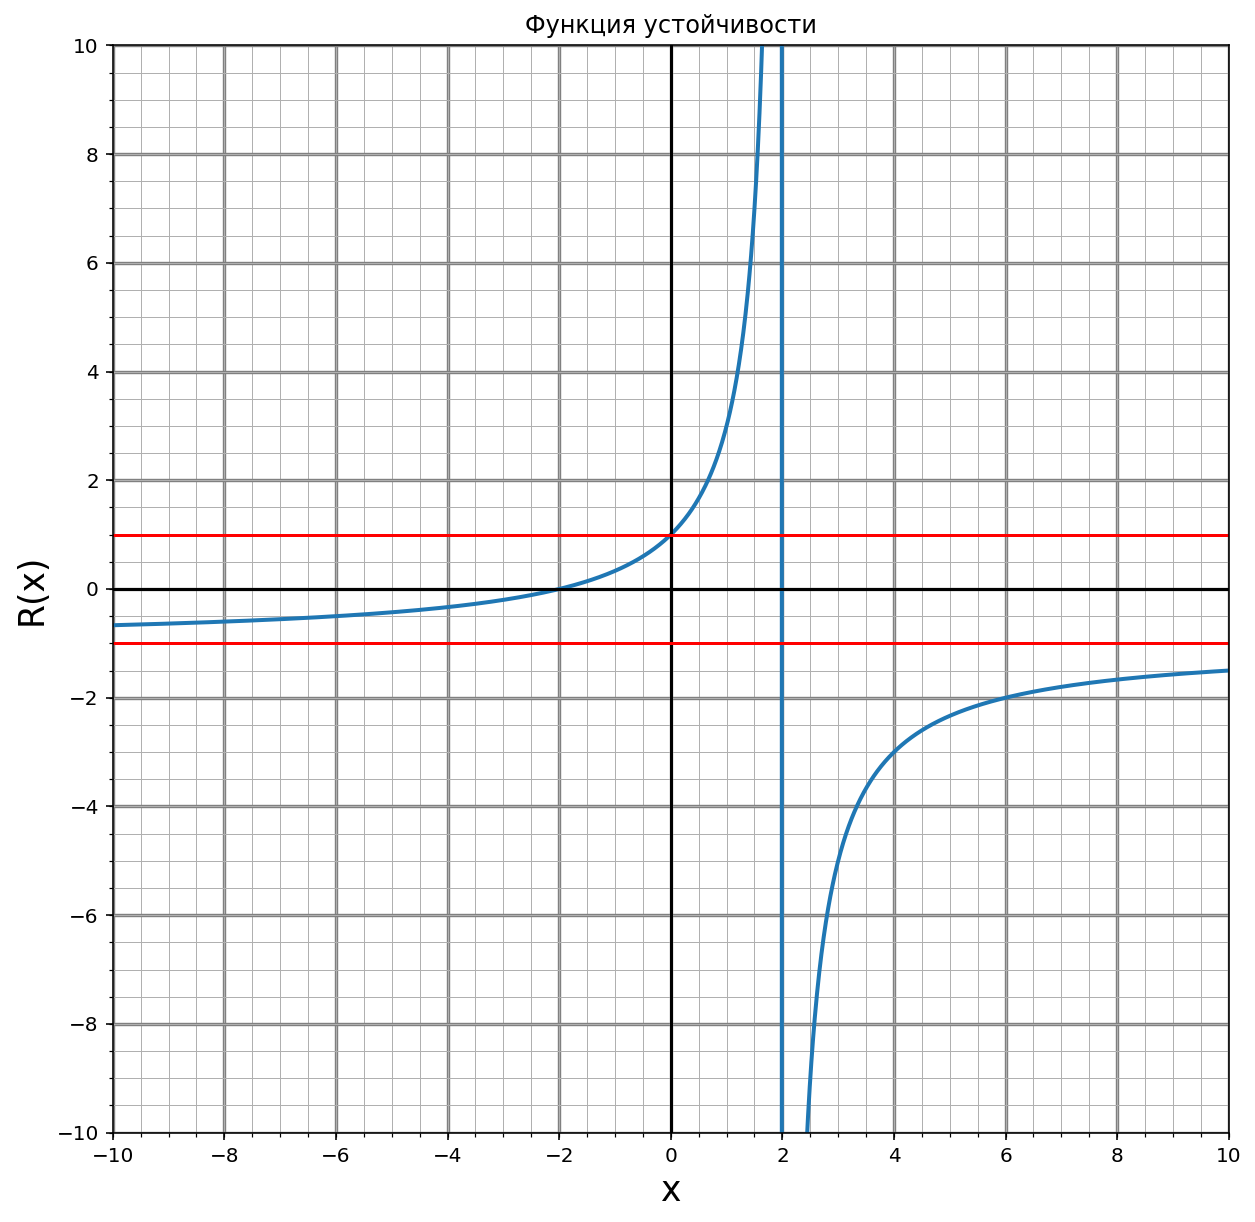

In [90]:
x = np.arange(-100, 100, 0.01)
R_x = R_z_vas(buch_table_2appr, x)

plt.figure(figsize=(10,10))
plt.plot(x, R_x[0], linewidth=2)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title('Функция устойчивости')
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('R(x)', fontsize='xx-large')

ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
plt.grid(True, which='major', linewidth = 1.7, color = 'grey')
plt.grid(True, which='minor', linewidth = 0.5)

plt.axhline(1, color ='red')
plt.axhline(-1, color='red')


Внутри выреза определнного красными линиями функция принимает значения по модулю не превосходящие единицы, то есть выполняется условие устойчивости метода

Решим численно задачу с начальными условиями:

$y_1(0) = 2, y_2(0) = 0$

In [13]:
y_0 = np.array([2, 0])
x_0 = 0
Tk = 20

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


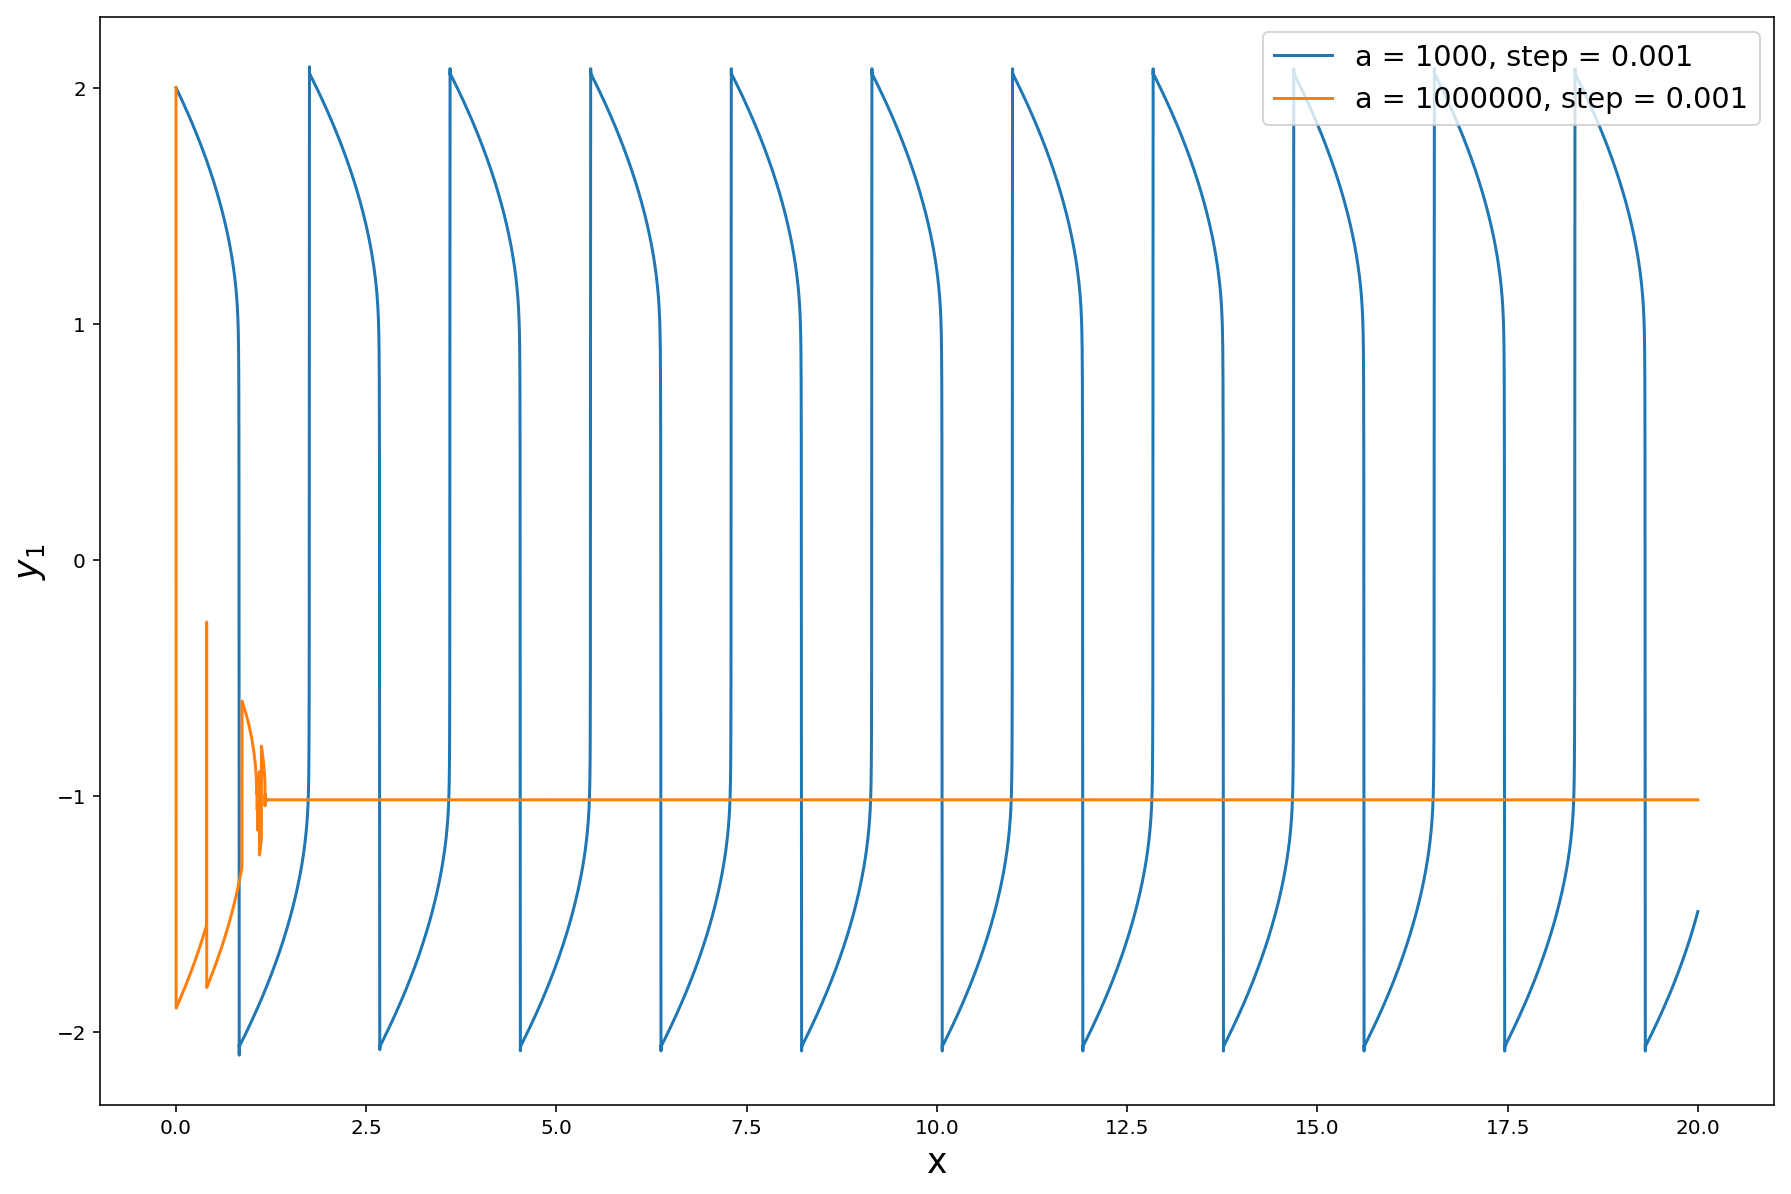

In [68]:
plt.figure(figsize=(15,10))
a = 10**3
step = 0.001
y, x = runge_kutt(buch_table_2appr, y_0, x_0, a, step, Tk, F, func_pol)
plt.plot(x, y[:, 0], label='a = {}, step = {}'.format(a, step))

a = 10**6
step = 0.001
y, x = runge_kutt(buch_table_2appr, y_0, x_0, a, step, Tk, F, func_pol)
plt.plot(x, y[:, 0], label='a = {}, step = {}'.format(a, step))

plt.legend(fontsize='x-large', loc=1)
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('$ y_1 $', fontsize='xx-large');

Как видим при увеличении жёсткости задача становится неустойчивой при заданном шаге. По-хорошему, шаг нужно уменьшить в столько раз, во сколько раз увеличилась жесткость(максимальное собственное значение почти равно жесткости). Но для вычислений при таком шаге потребуется большое количество время.

## 4appr

Используем таблицу 2 из задания

Построим функцию устойчивости:

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


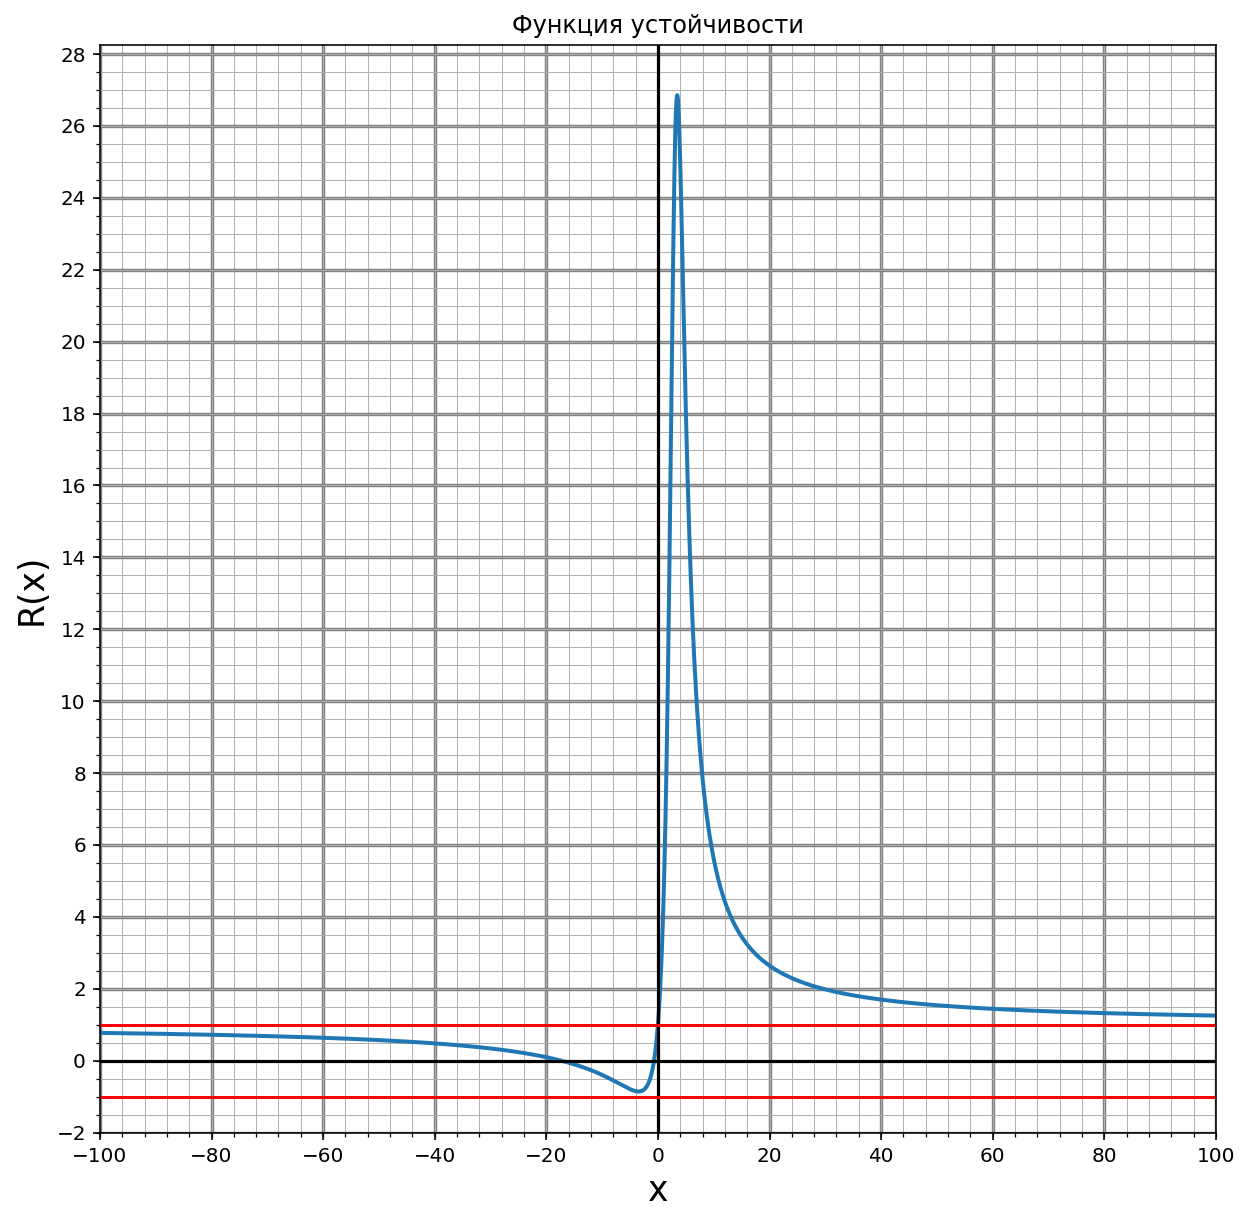

In [85]:
x = np.arange(-100, 100, 0.01)
R_x = [] 
for value in x:
    R_x.append(R_z_vas(buch_table_4appr, value))

plt.figure(figsize=(10,10))
plt.plot(x, R_x, linewidth=2)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlim(-100, 100)
plt.ylim(bottom=-2)
plt.title('Функция устойчивости')
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('R(x)', fontsize='xx-large')

ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
plt.grid(True, which='major', linewidth = 1.7, color = 'grey')
plt.grid(True, which='minor', linewidth = 0.5)

plt.axhline(1, color ='red')
plt.axhline(-1, color='red')

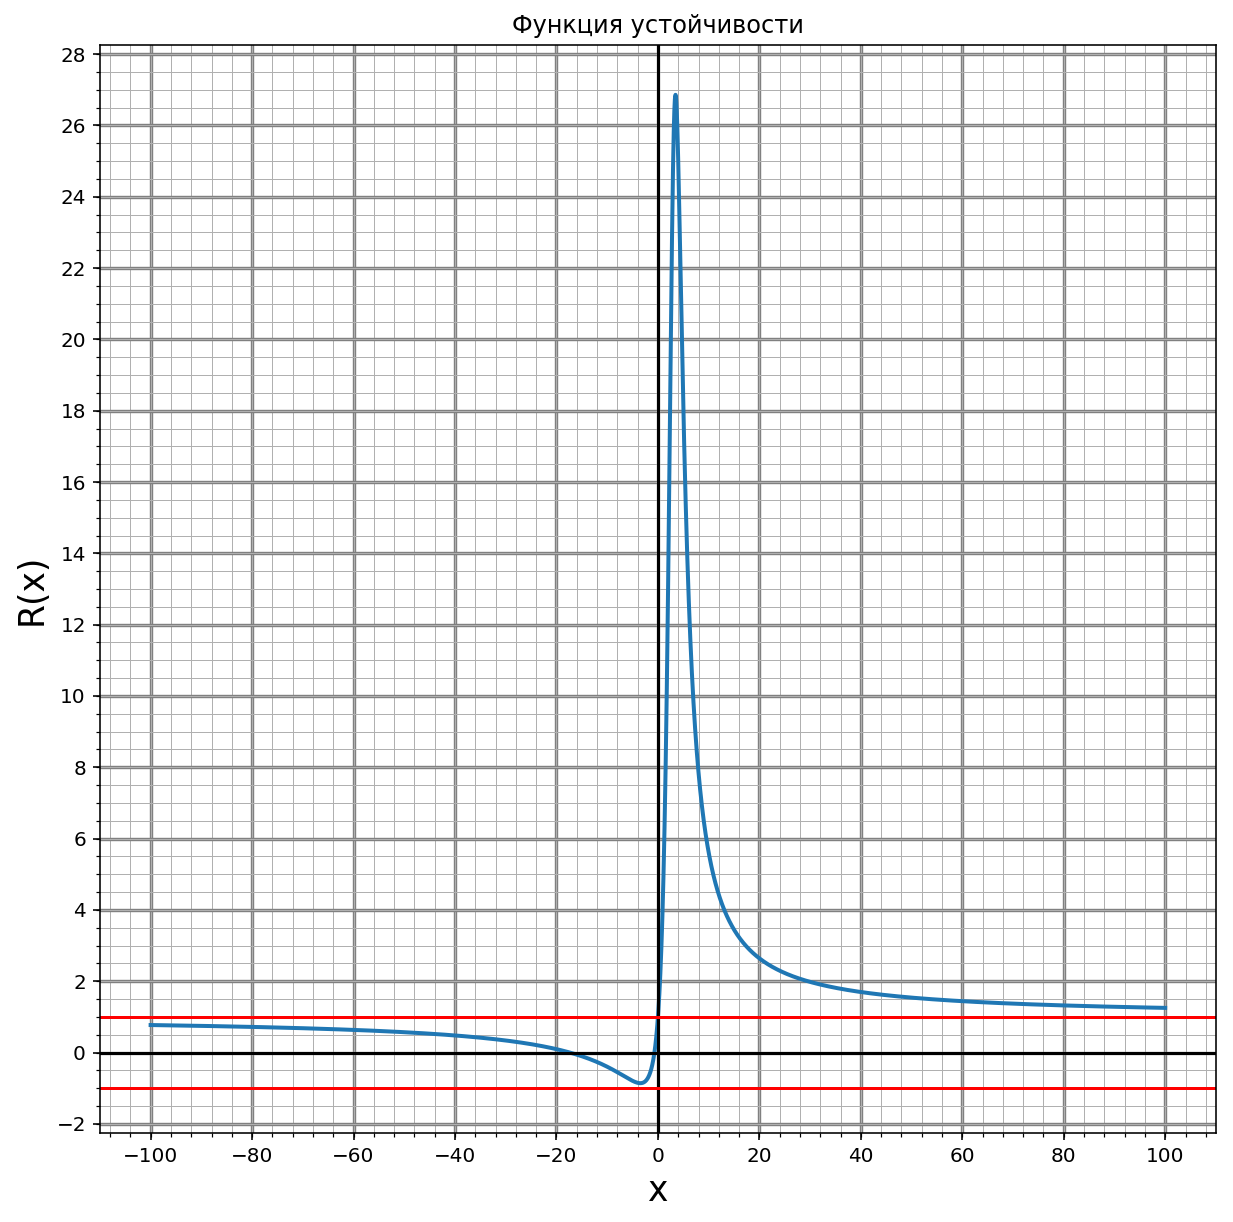

In [80]:
x = np.arange(-100, 100, 0.01)
R_x = [] 
for value in x:
    R_x.append(R_z_vas(buch_table_4appr, value))

plt.figure(figsize=(10,10))
plt.plot(x, R_x, linewidth=2)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
#plt.xlim(-100, 100)
#plt.ylim(bottom=-2)
plt.title('Функция устойчивости')
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('R(x)', fontsize='xx-large')

ax = plt.axes()
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
plt.grid(True, which='major', linewidth = 1.7, color = 'grey')
plt.grid(True, which='minor', linewidth = 0.5)

plt.axhline(1, color ='red')
plt.axhline(-1, color='red')

Решим численно задачу с начальными условиями:

$y_1(0) = 2, y_2(0) = 0$

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


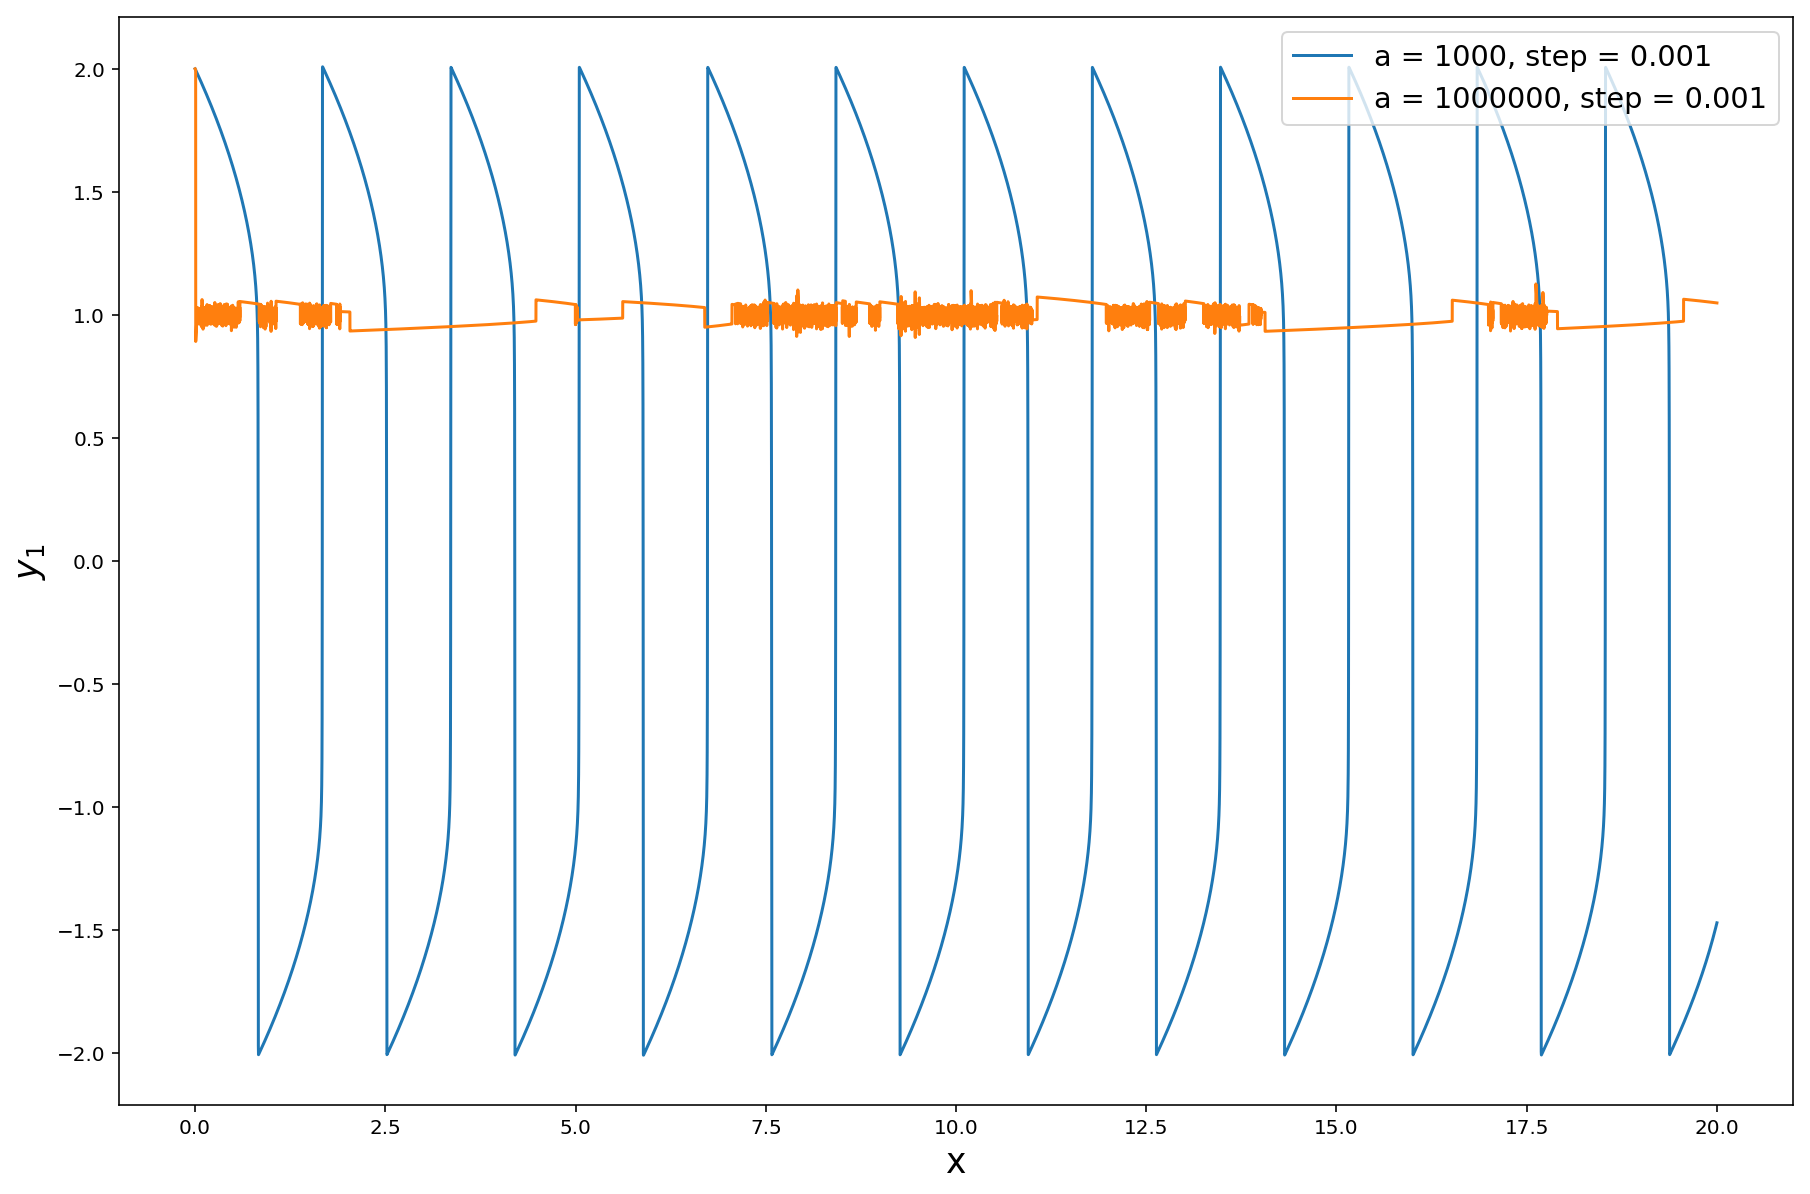

In [84]:
plt.figure(figsize=(15,10))
a = 10**3
step = 0.001
y, x = runge_kutt(buch_table_4appr, y_0, x_0, a, step, Tk, F, func_pol)
plt.plot(x, y[:, 0], label='a = {}, step = {}'.format(a, step))

a = 10**6
step = 0.001
y, x = runge_kutt(buch_table_4appr, y_0, x_0, a, step, Tk, F, func_pol)
plt.plot(x, y[:, 0], label='a = {}, step = {}'.format(a, step))

plt.legend(fontsize='x-large', loc=1)
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('$ y_1 $', fontsize='xx-large');

## 6appr

Используем таблицу 1 из задания

Построим функцию устойчивости:

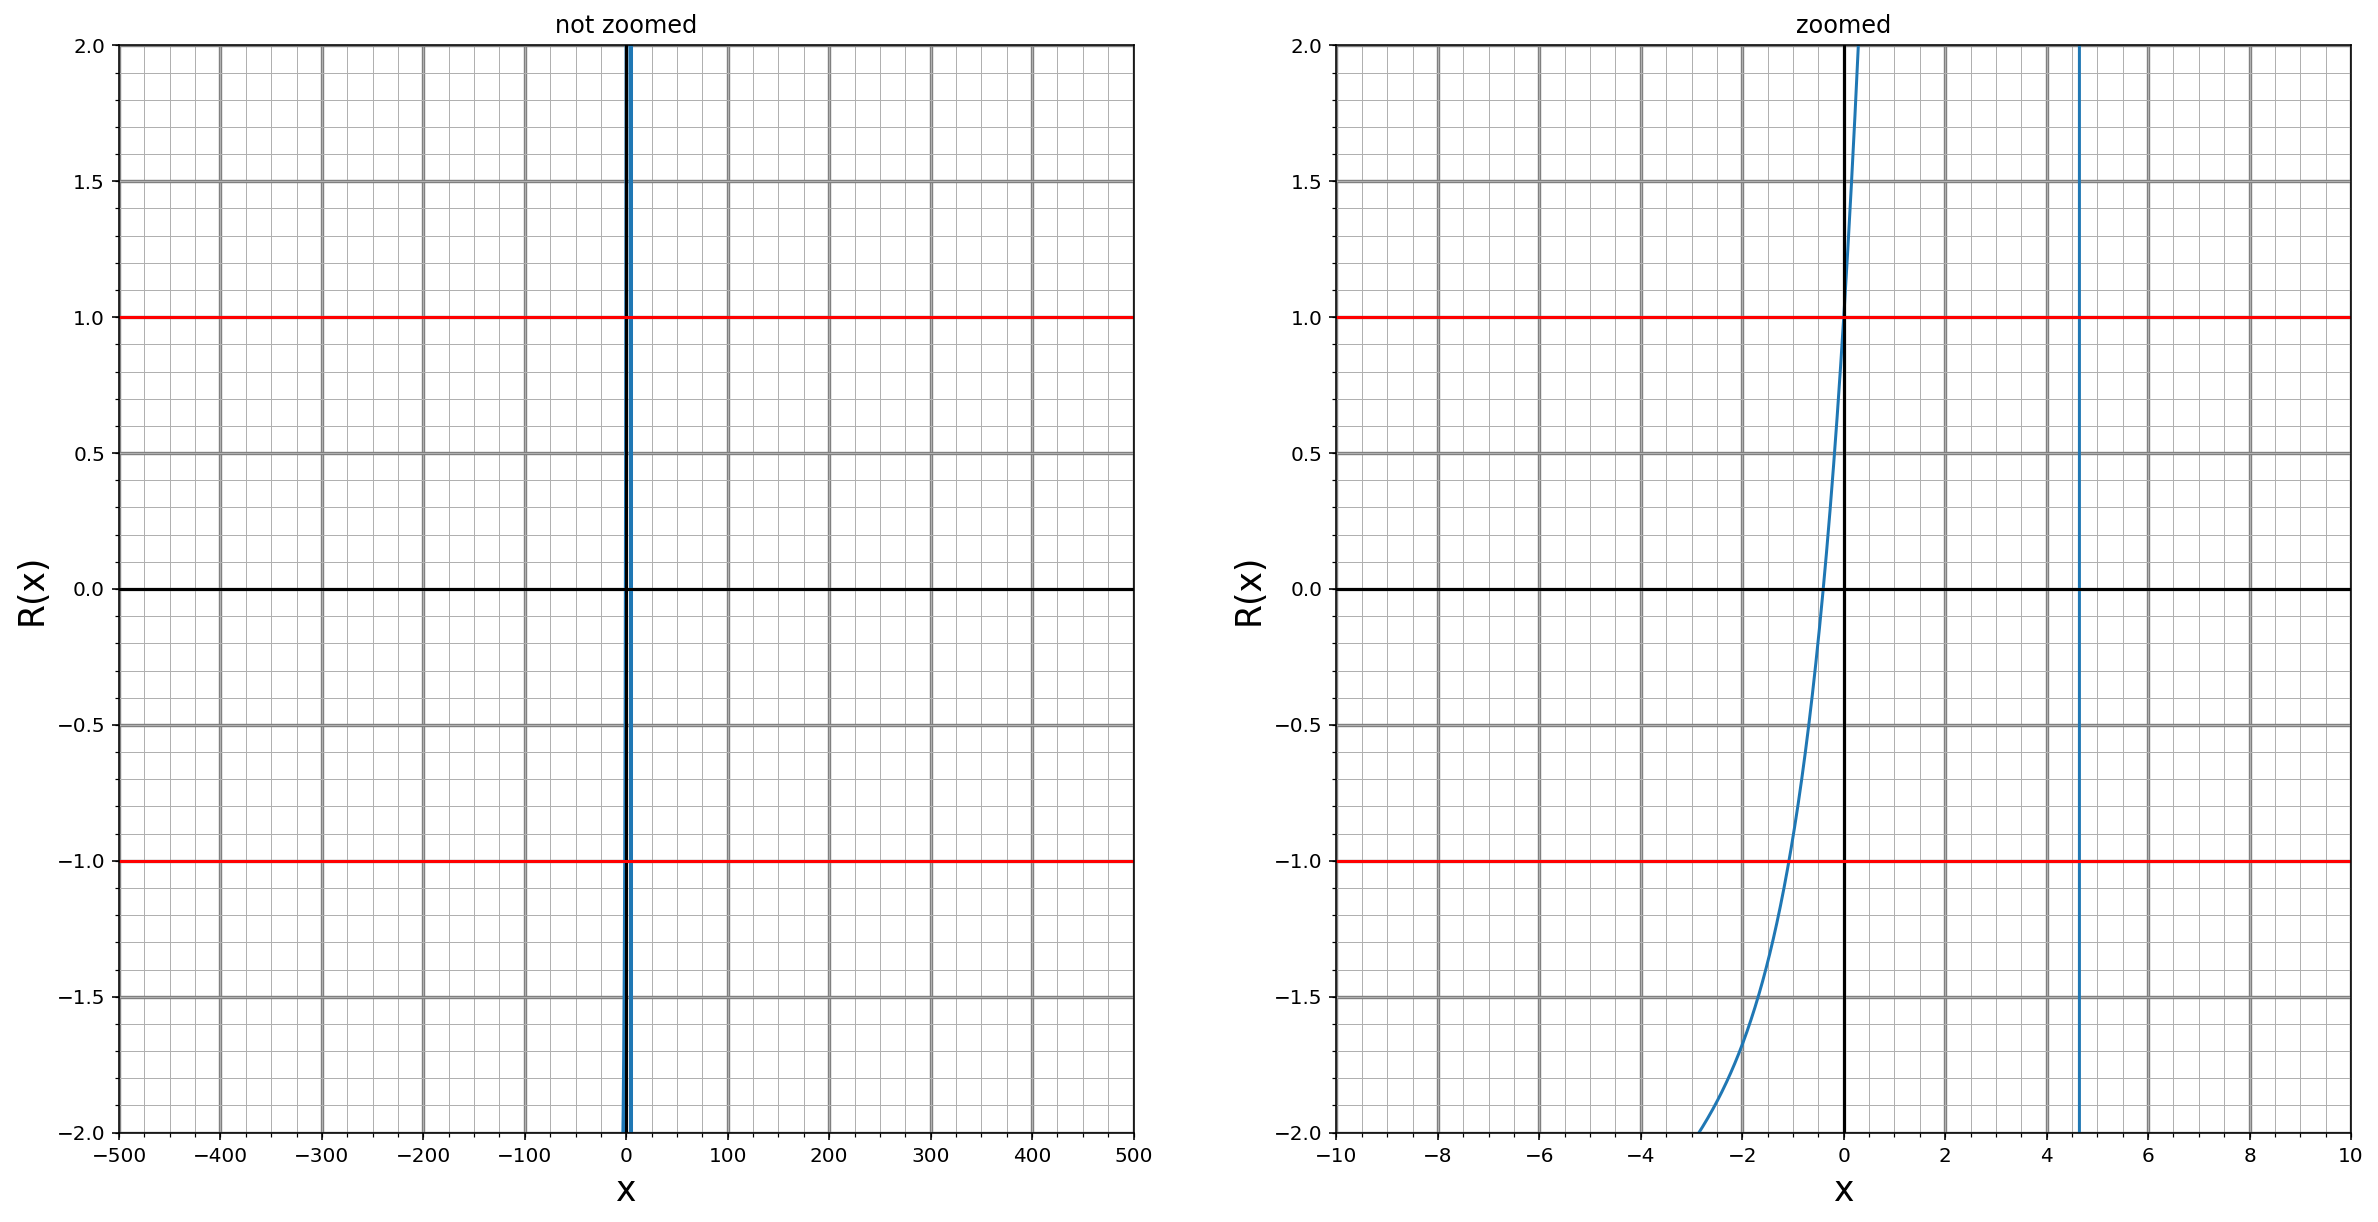

In [81]:
x = np.arange(-500, 500, 0.01)
R_x = [] 
for value in x:
    R_x.append(R_z_vas(buch_table_6appr, value))

plt.figure(figsize=(20,10))
plt.title('Функция устойчивости')
ax1 = plt.subplot(121)
ax1.plot(x, R_x, linewidth=2)

ax2 = plt.subplot(122)
ax2.plot(x, R_x)

ax1.axhline(0, color='black')
ax1.axvline(0, color='black')
ax2.axhline(0, color='black')
ax2.axvline(0, color='black')
ax1.axhline(1, color='red')
ax1.axhline(-1, color='red')
ax2.axhline(1, color='red')
ax2.axhline(-1, color='red')
ax1.set_xlim(-500, 500)
ax2.set_xlim(-10, 10)

ax1.set_ylim(-2, 2)
ax2.set_ylim(-2, 2)

ax1.set_title('not zoomed')
ax2.set_title('zoomed')

ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(25))
ax1.grid(True, which='major', linewidth = 1.7, color = 'grey')
ax1.grid(True, which='minor', linewidth = 0.5)

ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax2.grid(True, which='major', linewidth = 1.7, color = 'grey')
ax2.grid(True, which='minor', linewidth = 0.5)

ax1.set_xlabel('x', fontsize='xx-large')
ax1.set_ylabel('R(x)', fontsize='xx-large')
ax2.set_xlabel('x', fontsize='xx-large')
ax2.set_ylabel('R(x)', fontsize='xx-large');


Решим численно задачу с начальными условиями:

$y_1(0) = 2, y_2(0) = 0$

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1400.
  warnings.warn(msg, RuntimeWarning)


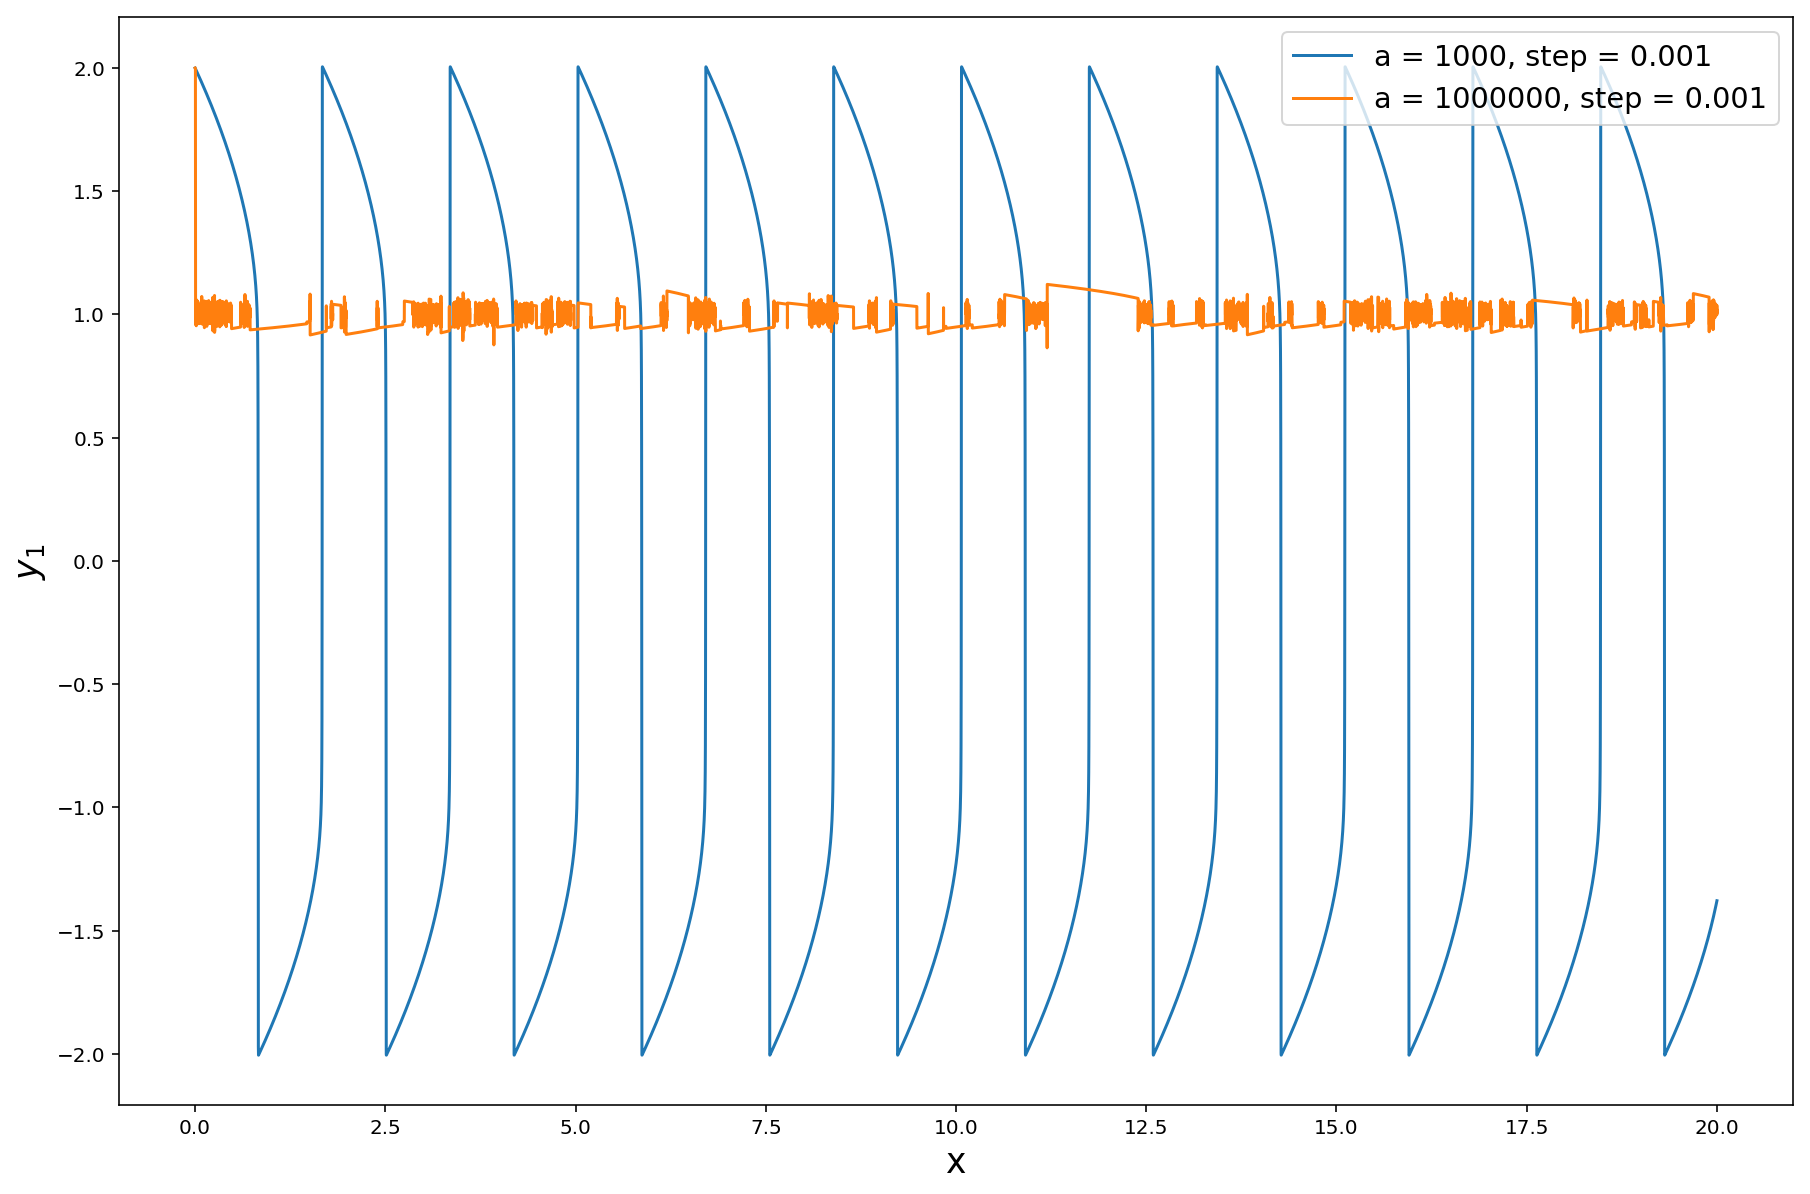

In [114]:
plt.figure(figsize=(15,10))
a = 10**3
step = 0.001
y, x = runge_kutt(buch_table_6appr, y_0, x_0, a, step, Tk, F, func_pol)
plt.plot(x, y[:, 0], label='a = {}, step = {}'.format(a, step))

a = 10**6
step = 0.001
y, x = runge_kutt(buch_table_6appr, y_0, x_0, a, step, Tk, F, func_pol)
plt.plot(x, y[:, 0], label='a = {}, step = {}'.format(a, step))

plt.legend(fontsize='x-large', loc=1)
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('$ y_1 $', fontsize='xx-large');

## Сравнение

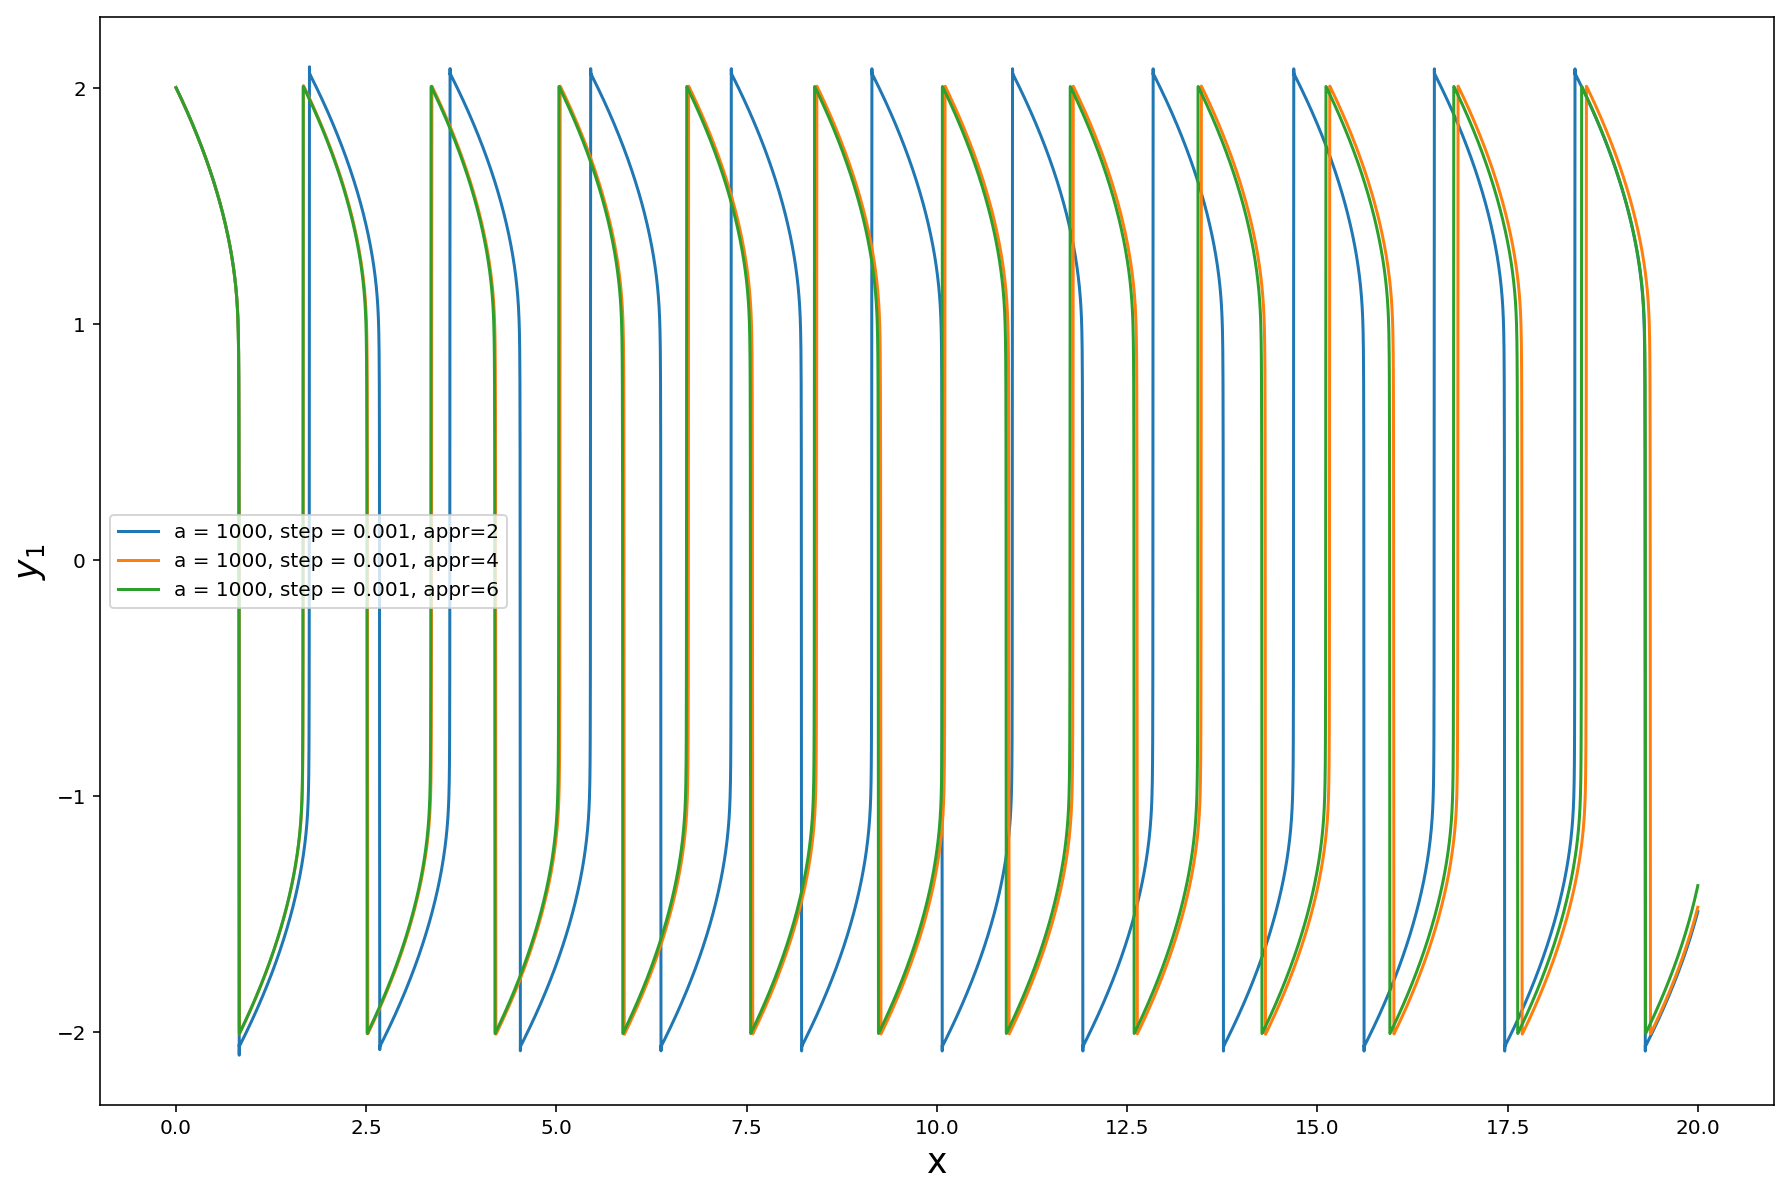

In [116]:
plt.figure(figsize=(15,10))
a = 10**3
step = 0.001
y, x = runge_kutt(buch_table_2appr, y_0, x_0, a, step, Tk, F, func_pol)
plt.plot(x, y[:, 0], label='a = {}, step = {}, appr={}'.format(a, step, 2))
y, x = runge_kutt(buch_table_4appr, y_0, x_0, a, step, Tk, F, func_pol)
plt.plot(x, y[:, 0], label='a = {}, step = {}, appr={}'.format(a, step, 4))
y, x = runge_kutt(buch_table_6appr, y_0, x_0, a, step, Tk, F, func_pol)
plt.plot(x, y[:, 0], label='a = {}, step = {}, appr={}'.format(a, step, 6))
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('$y_1$', fontsize='xx-large')
plt.legend()

Как видим, при больших t решения, найденные разными методами, начинают расходится

## Сравнение с однократно диагонально неявным методом 

Для начала построим функцию устойчивости метода(таблица 4)

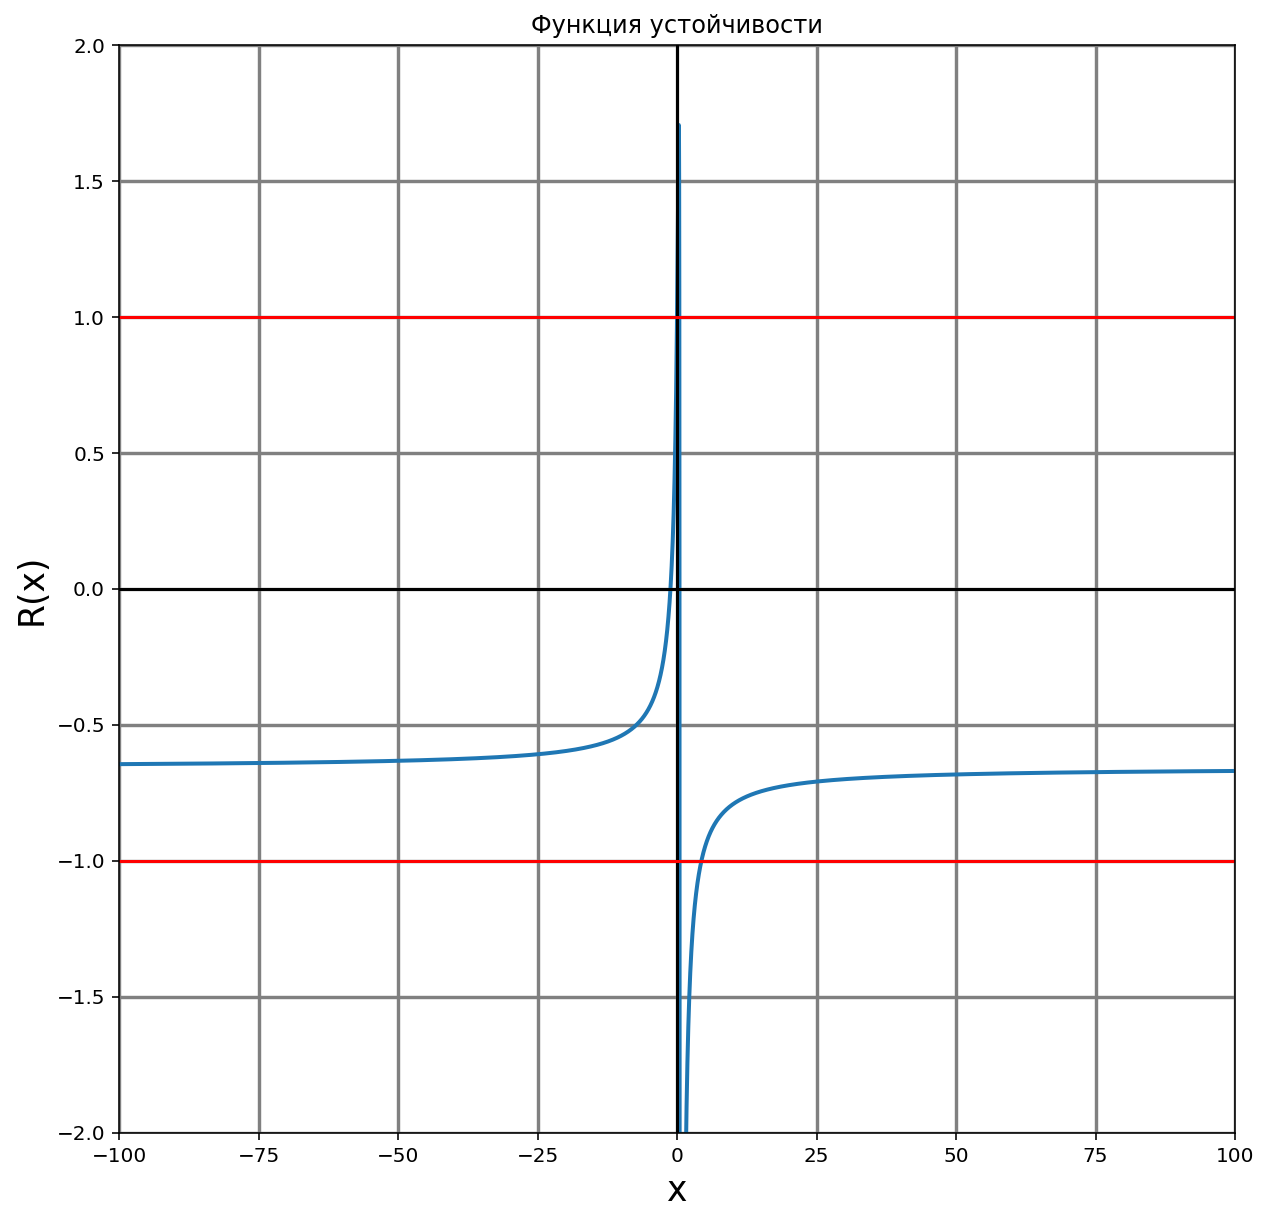

In [84]:
x = np.arange(-100, 100, 0.01)
R_x = [] 
for value in x:
    R_x.append(R_z_vas(buch_table_one, value))

plt.figure(figsize=(10,10))
plt.plot(x, R_x, linewidth=2)
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.xlim(-100, 100)
plt.ylim(-2, 2)
plt.title('Функция устойчивости')
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('R(x)', fontsize='xx-large')

#ax = plt.axes()
#ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
#ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
#ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
plt.grid(True, which='major', linewidth = 1.7, color = 'grey')
plt.grid(True, which='minor', linewidth = 0.5)

plt.axhline(1, color ='red')
plt.axhline(-1, color='red')

Видно, что метод в отлчии от предыдущих устойчив почти при всех положительных х, а значит, и почти при всех шагах, так как собственные значения системы положительны.

In [100]:
a = 10**3
step1 = 0.0001
y1, x1 = runge_kutt(buch_table_2appr, y_0, x_0, a, step1, Tk, F, func_pol)
y_s1, x_s1 = runge_kutt(buch_table_one, y_0, x_0, a, step1, Tk, F, func_pol)

step2 = 0.001
y2, x2 = runge_kutt(buch_table_2appr, y_0, x_0, a, step2, Tk, F, func_pol)
y_s2, x_s2 = runge_kutt(buch_table_one, y_0, x_0, a, step2, Tk, F, func_pol)

step3 = 0.01
y3, x3 = runge_kutt(buch_table_2appr, y_0, x_0, a, step3, Tk, F, func_pol)
y_s3, x_s3 = runge_kutt(buch_table_one, y_0, x_0, a, step3, Tk, F, func_pol)

a = 10**6
step1 = 0.0001
y1a, x1a = runge_kutt(buch_table_2appr, y_0, x_0, a, step1, Tk, F, func_pol)
y_s1a, x_s1a = runge_kutt(buch_table_one, y_0, x_0, a, step1, Tk, F, func_pol)

step2 = 0.001
y2a, x2a = runge_kutt(buch_table_2appr, y_0, x_0, a, step2, Tk, F, func_pol)
y_s2a, x_s2a = runge_kutt(buch_table_one, y_0, x_0, a, step2, Tk, F, func_pol)

step3 = 0.01
y3a, x3a = runge_kutt(buch_table_2appr, y_0, x_0, a, step3, Tk, F, func_pol)
y_s3a, x_s3a = runge_kutt(buch_table_one, y_0, x_0, a, step3, Tk, F, func_pol)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 600.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The number of calls to function has reached maxfev = 1000.
  warnings.warn(msg, RuntimeWarning)


Сравним метод с 2 порядком аппроксимации с данным методом(табл.4)

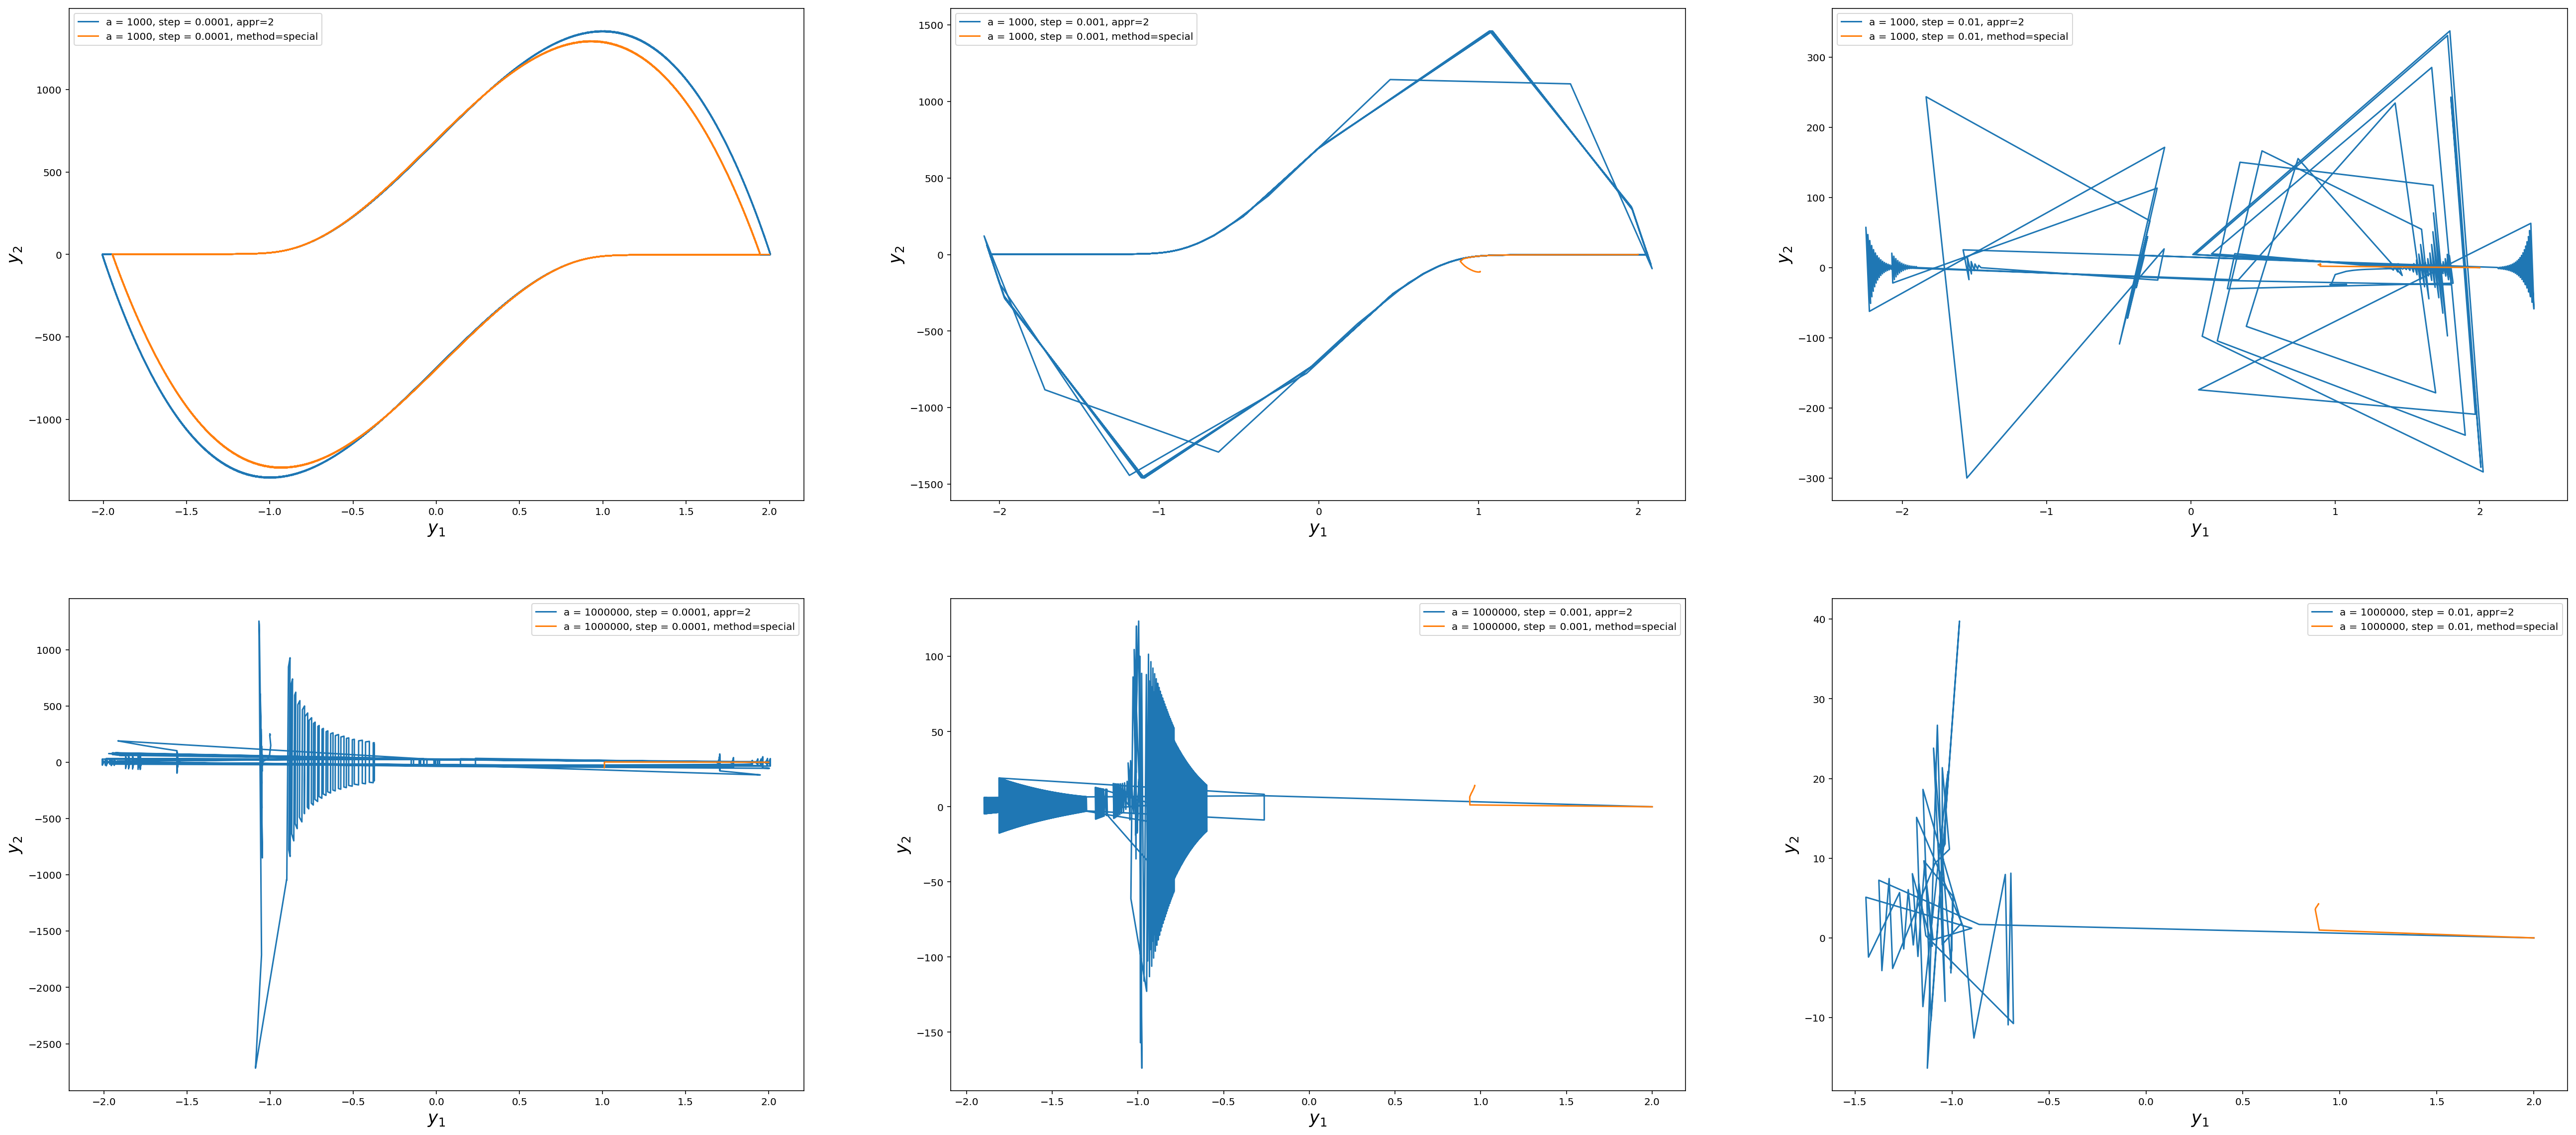

In [102]:
plt.figure(figsize=(45,20))

a = 10**3
ax1 = plt.subplot(231)
ax1.plot(y1[:, 0], y1[:, 1], label='a = {}, step = {}, appr={}'.format(a, step1, 2))
ax1.plot(y_s1[:, 0], y_s1[:, 1], label='a = {}, step = {}, method={}'.format(a, step1, 'special'))
ax1.set_xlabel('$y_1$', fontsize='xx-large')
ax1.set_ylabel('$y_2$', fontsize='xx-large')

ax2 = plt.subplot(232)
ax2.plot(y2[:, 0], y2[:, 1], label='a = {}, step = {}, appr={}'.format(a, step2, 2))
ax2.plot(y_s2[:, 0], y_s2[:, 1], label='a = {}, step = {}, method={}'.format(a, step2, 'special'))
ax2.set_xlabel('$y_1$', fontsize='xx-large')
ax2.set_ylabel('$y_2$', fontsize='xx-large')

ax3 = plt.subplot(233)
ax3.plot(y3[:, 0], y3[:, 1], label='a = {}, step = {}, appr={}'.format(a, step3, 2))
ax3.plot(y_s3[:, 0], y_s3[:, 1], label='a = {}, step = {}, method={}'.format(a, step3, 'special'))
ax3.set_xlabel('$y_1$', fontsize='xx-large')
ax3.set_ylabel('$y_2$', fontsize='xx-large')

a = 10**6
ax4 = plt.subplot(234)
ax4.plot(y1a[:, 0], y1a[:, 1], label='a = {}, step = {}, appr={}'.format(a, step1, 2))
ax4.plot(y_s1a[:, 0], y_s1a[:, 1], label='a = {}, step = {}, method={}'.format(a, step1, 'special'))
ax4.set_xlabel('$y_1$', fontsize='xx-large')
ax4.set_ylabel('$y_2$', fontsize='xx-large')

ax5 = plt.subplot(235)
ax5.plot(y2a[:, 0], y2a[:, 1], label='a = {}, step = {}, appr={}'.format(a, step2, 2))
ax5.plot(y_s2a[:, 0], y_s2a[:, 1], label='a = {}, step = {}, method={}'.format(a, step2, 'special'))
ax5.set_xlabel('$y_1$', fontsize='xx-large')
ax5.set_ylabel('$y_2$', fontsize='xx-large')

ax6 = plt.subplot(236)
ax6.plot(y3a[:, 0], y3a[:, 1], label='a = {}, step = {}, appr={}'.format(a, step3, 2))
ax6.plot(y_s3a[:, 0], y_s3a[:, 1], label='a = {}, step = {}, method={}'.format(a, step3, 'special'))
ax6.set_xlabel('$y_1$', fontsize='xx-large')
ax6.set_ylabel('$y_2$', fontsize='xx-large')


ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()

Заметно отличие: метод(табл 4) при больших шагах уже не решает задачу в отличие от методов, использованных ранее.

In [104]:
a = 10**3
step1 = 0.0001
y1, x1 = runge_kutt(buch_table_4appr, y_0, x_0, a, step1, Tk, F, func_pol)
y_s1, x_s1 = runge_kutt(buch_table_one, y_0, x_0, a, step1, Tk, F, func_pol)

step2 = 0.001
y2, x2 = runge_kutt(buch_table_4appr, y_0, x_0, a, step2, Tk, F, func_pol)
y_s2, x_s2 = runge_kutt(buch_table_one, y_0, x_0, a, step2, Tk, F, func_pol)

step3 = 0.01
y3, x3 = runge_kutt(buch_table_4appr, y_0, x_0, a, step3, Tk, F, func_pol)
y_s3, x_s3 = runge_kutt(buch_table_one, y_0, x_0, a, step3, Tk, F, func_pol)

step4 = 0.1
y4, x4 = runge_kutt(buch_table_4appr, y_0, x_0, a, step4, Tk, F, func_pol)
y_s4, x_s4 = runge_kutt(buch_table_one, y_0, x_0, a, step4, Tk, F, func_pol)

Сравним метод с 4 порядком аппроксимации с данным методом(табл.4)

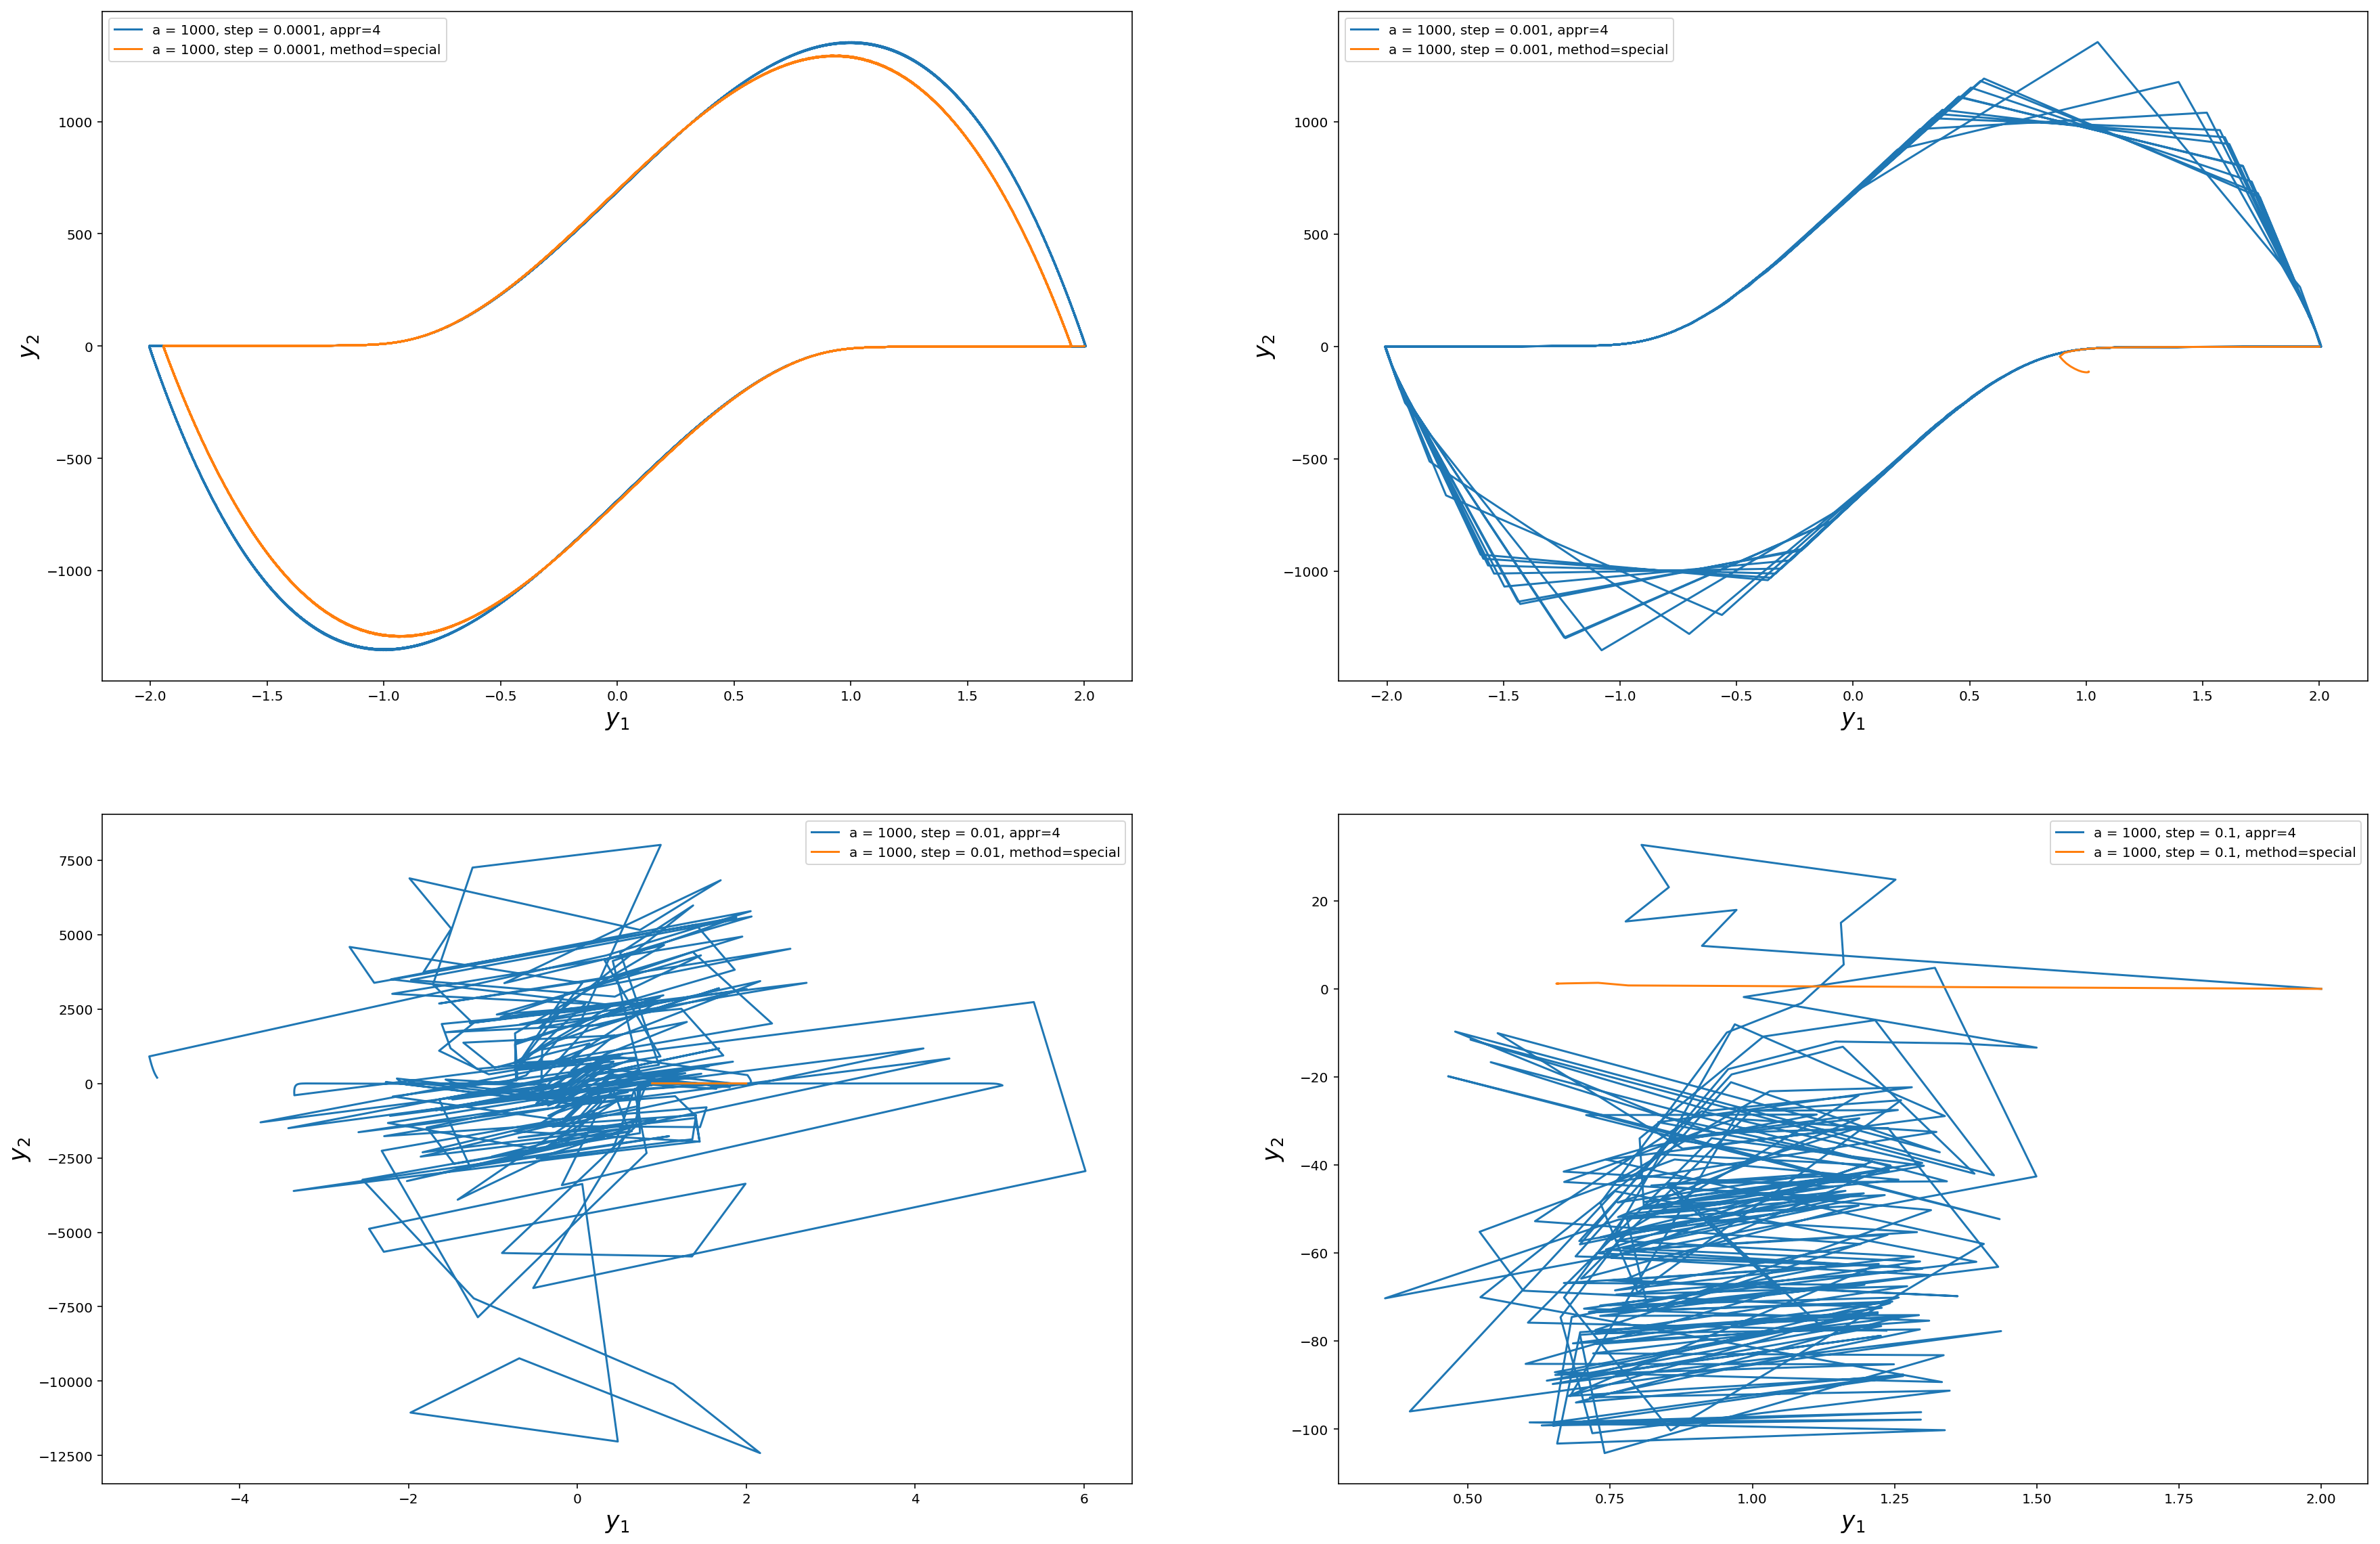

In [105]:
plt.figure(figsize=(30,20))

appr = 4

ax1 = plt.subplot(221)
ax1.plot(y1[:, 0], y1[:, 1], label='a = {}, step = {}, appr={}'.format(a, step1, appr))
ax1.plot(y_s1[:, 0], y_s1[:, 1], label='a = {}, step = {}, method={}'.format(a, step1, 'special'))
ax1.set_xlabel('$y_1$', fontsize='xx-large')
ax1.set_ylabel('$y_2$', fontsize='xx-large')

ax2 = plt.subplot(222)
ax2.plot(y2[:, 0], y2[:, 1], label='a = {}, step = {}, appr={}'.format(a, step2, appr))
ax2.plot(y_s2[:, 0], y_s2[:, 1], label='a = {}, step = {}, method={}'.format(a, step2, 'special'))
ax2.set_xlabel('$y_1$', fontsize='xx-large')
ax2.set_ylabel('$y_2$', fontsize='xx-large')

ax3 = plt.subplot(223)
ax3.plot(y3[:, 0], y3[:, 1], label='a = {}, step = {}, appr={}'.format(a, step3, appr))
ax3.plot(y_s3[:, 0], y_s3[:, 1], label='a = {}, step = {}, method={}'.format(a, step3, 'special'))
ax3.set_xlabel('$y_1$', fontsize='xx-large')
ax3.set_ylabel('$y_2$', fontsize='xx-large')

ax4 = plt.subplot(224)
ax4.plot(y4[:, 0], y4[:, 1], label='a = {}, step = {}, appr={}'.format(a, step4, appr))
ax4.plot(y_s4[:, 0], y_s4[:, 1], label='a = {}, step = {}, method={}'.format(a, step4, 'special'))
ax4.set_xlabel('$y_1$', fontsize='xx-large')
ax4.set_ylabel('$y_2$', fontsize='xx-large')




ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

Метод(табл.4) видно, что справляется хуже.

In [106]:
a = 10**3
step1 = 0.0001
y1, x1 = runge_kutt(buch_table_6appr, y_0, x_0, a, step1, Tk, F, func_pol)
y_s1, x_s1 = runge_kutt(buch_table_one, y_0, x_0, a, step1, Tk, F, func_pol)

step2 = 0.001
y2, x2 = runge_kutt(buch_table_6appr, y_0, x_0, a, step2, Tk, F, func_pol)
y_s2, x_s2 = runge_kutt(buch_table_one, y_0, x_0, a, step2, Tk, F, func_pol)

step3 = 0.01
y3, x3 = runge_kutt(buch_table_6appr, y_0, x_0, a, step3, Tk, F, func_pol)
y_s3, x_s3 = runge_kutt(buch_table_one, y_0, x_0, a, step3, Tk, F, func_pol)

step4 = 0.1
y4, x4 = runge_kutt(buch_table_6appr, y_0, x_0, a, step4, Tk, F, func_pol)
y_s4, x_s4 = runge_kutt(buch_table_one, y_0, x_0, a, step4, Tk, F, func_pol)

Сравним метод с 6 порядком аппроксимации с данным методом(табл.4)

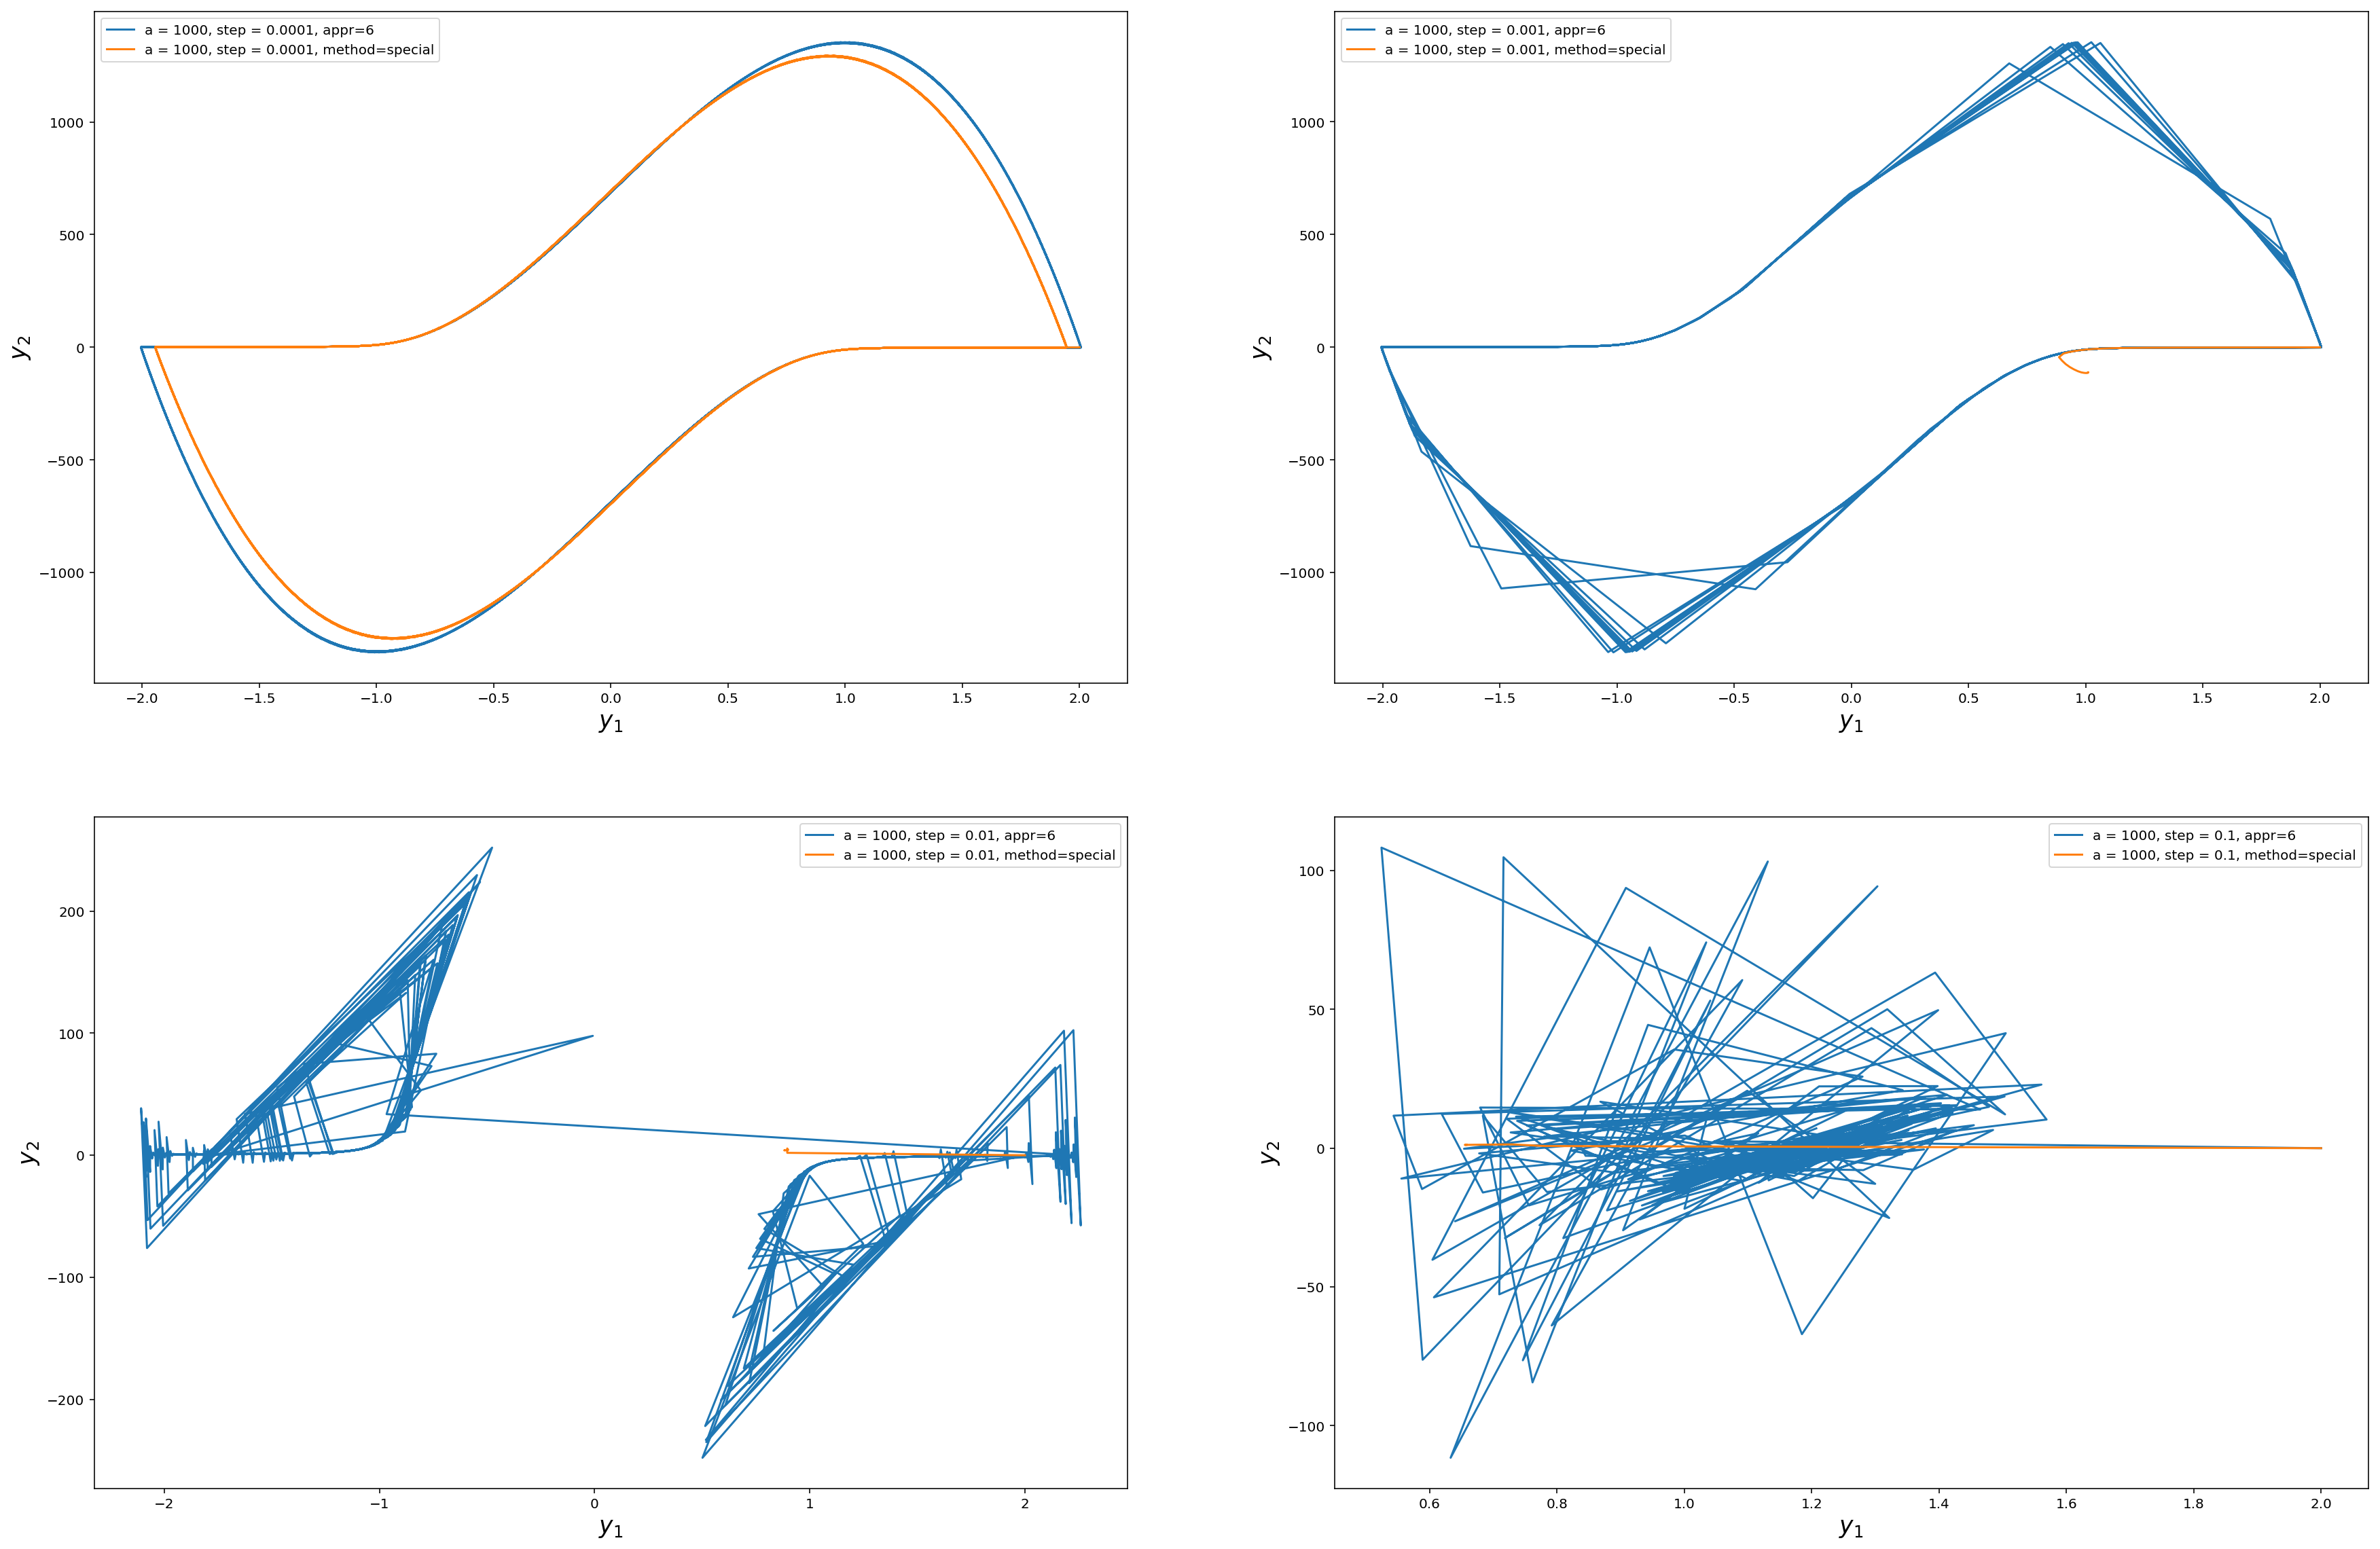

In [107]:
plt.figure(figsize=(30,20))

appr = 6

ax1 = plt.subplot(221)
ax1.plot(y1[:, 0], y1[:, 1], label='a = {}, step = {}, appr={}'.format(a, step1, appr))
ax1.plot(y_s1[:, 0], y_s1[:, 1], label='a = {}, step = {}, method={}'.format(a, step1, 'special'))
ax1.set_xlabel('$y_1$', fontsize='xx-large')
ax1.set_ylabel('$y_2$', fontsize='xx-large')

ax2 = plt.subplot(222)
ax2.plot(y2[:, 0], y2[:, 1], label='a = {}, step = {}, appr={}'.format(a, step2, appr))
ax2.plot(y_s2[:, 0], y_s2[:, 1], label='a = {}, step = {}, method={}'.format(a, step2, 'special'))
ax2.set_xlabel('$y_1$', fontsize='xx-large')
ax2.set_ylabel('$y_2$', fontsize='xx-large')

ax3 = plt.subplot(223)
ax3.plot(y3[:, 0], y3[:, 1], label='a = {}, step = {}, appr={}'.format(a, step3, appr))
ax3.plot(y_s3[:, 0], y_s3[:, 1], label='a = {}, step = {}, method={}'.format(a, step3, 'special'))
ax3.set_xlabel('$y_1$', fontsize='xx-large')
ax3.set_ylabel('$y_2$', fontsize='xx-large')

ax4 = plt.subplot(224)
ax4.plot(y4[:, 0], y4[:, 1], label='a = {}, step = {}, appr={}'.format(a, step4, appr))
ax4.plot(y_s4[:, 0], y_s4[:, 1], label='a = {}, step = {}, method={}'.format(a, step4, 'special'))
ax4.set_xlabel('$y_1$', fontsize='xx-large')
ax4.set_ylabel('$y_2$', fontsize='xx-large')




ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

Аналогично предыдущим сравнениям, видно, что данный метод(табл.4) "не справляется" при больших шагах 

## Очень жесткая задача

Попробуем решить задачу с жёсткостью порядка $10^6$

In [61]:
y_s_stiff_next, x_s_stiff_next = runge_kutt(buch_table_one, y_s_s[-1], x_s_s[-1], a, 0.000001, 7, F, func_pol)

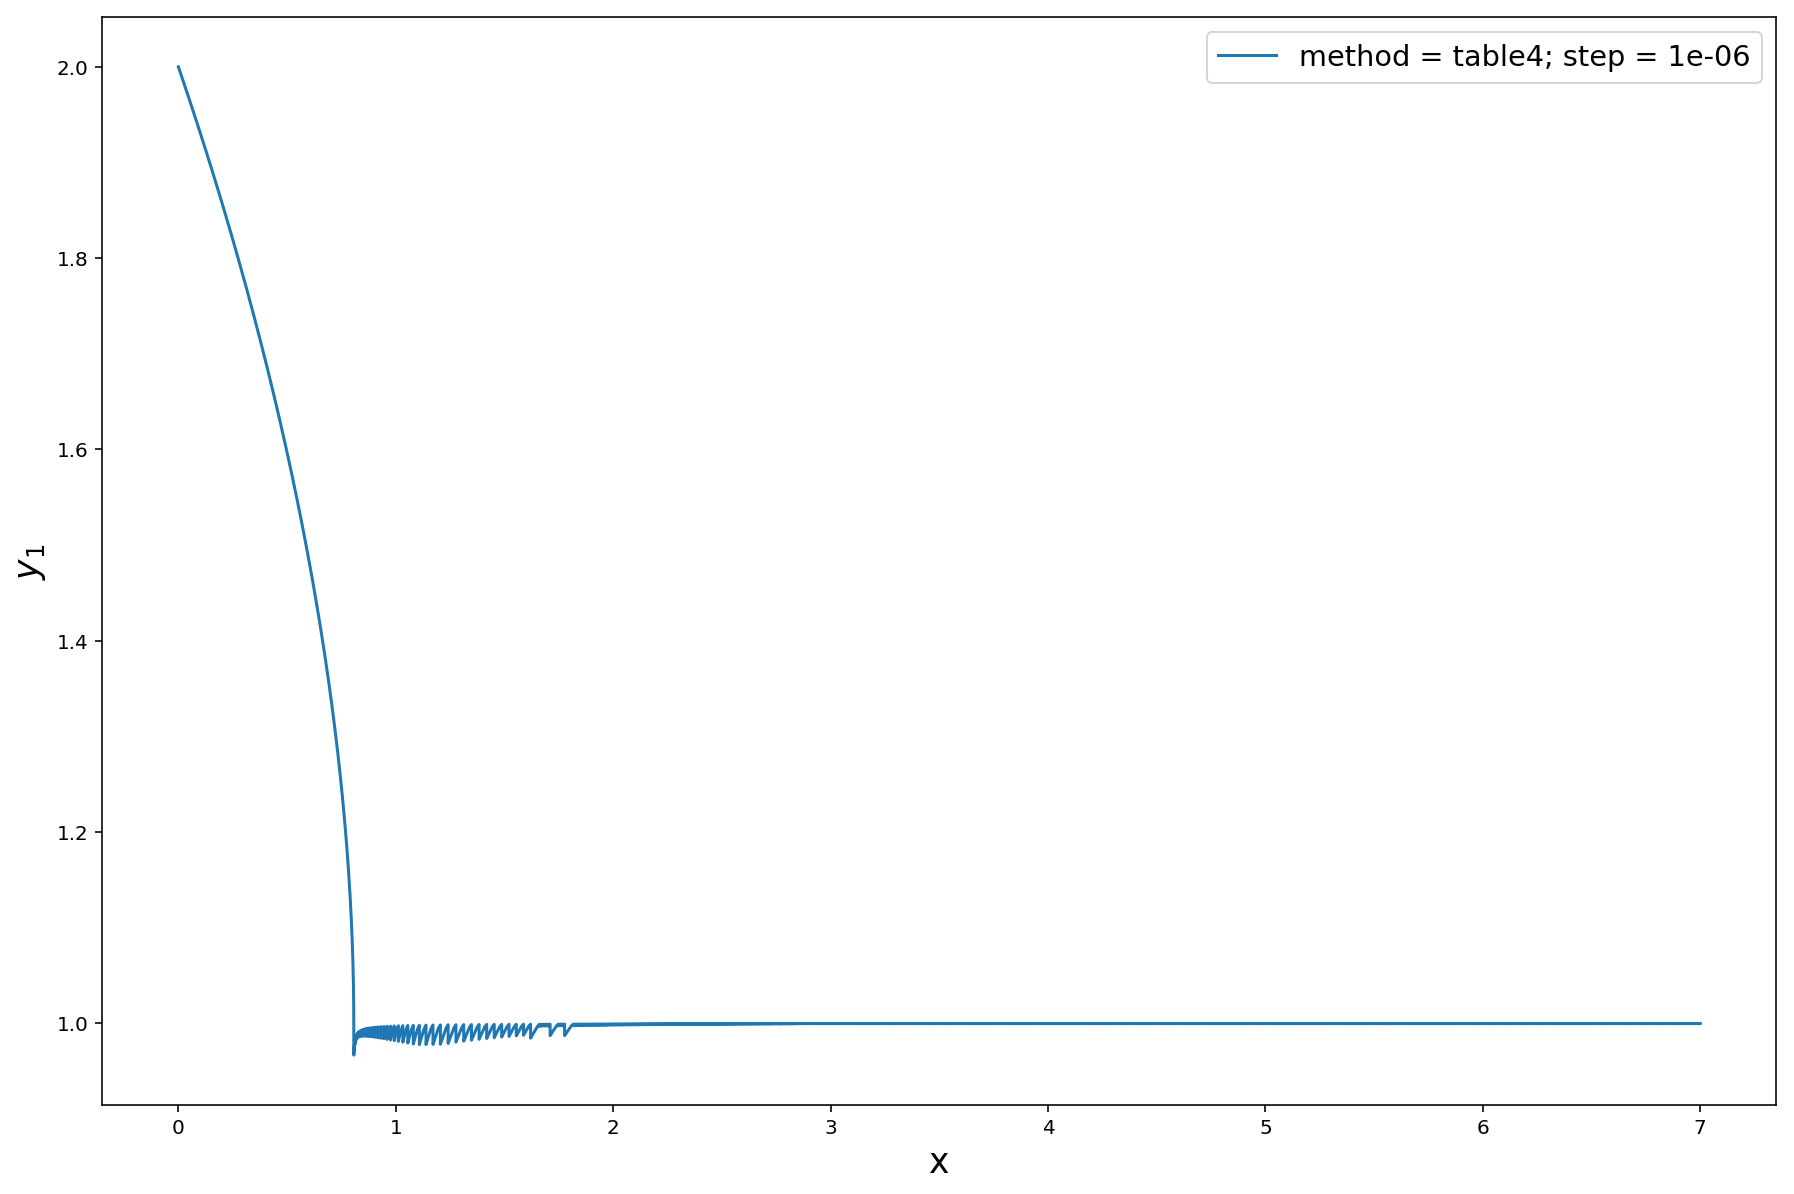

In [94]:
plt.figure(figsize=(15,10))
plt.plot(x_s_s, y_s_s[:, 0], label = 'method = {}; step = {}'.format('table4', 10**(-6)))

plt.xlabel('x', fontsize='xx-large')
plt.ylabel('$y_1$', fontsize='xx-large')
plt.legend(fontsize='x-large', loc=1);

Увеличим масштаб и видим один шум.

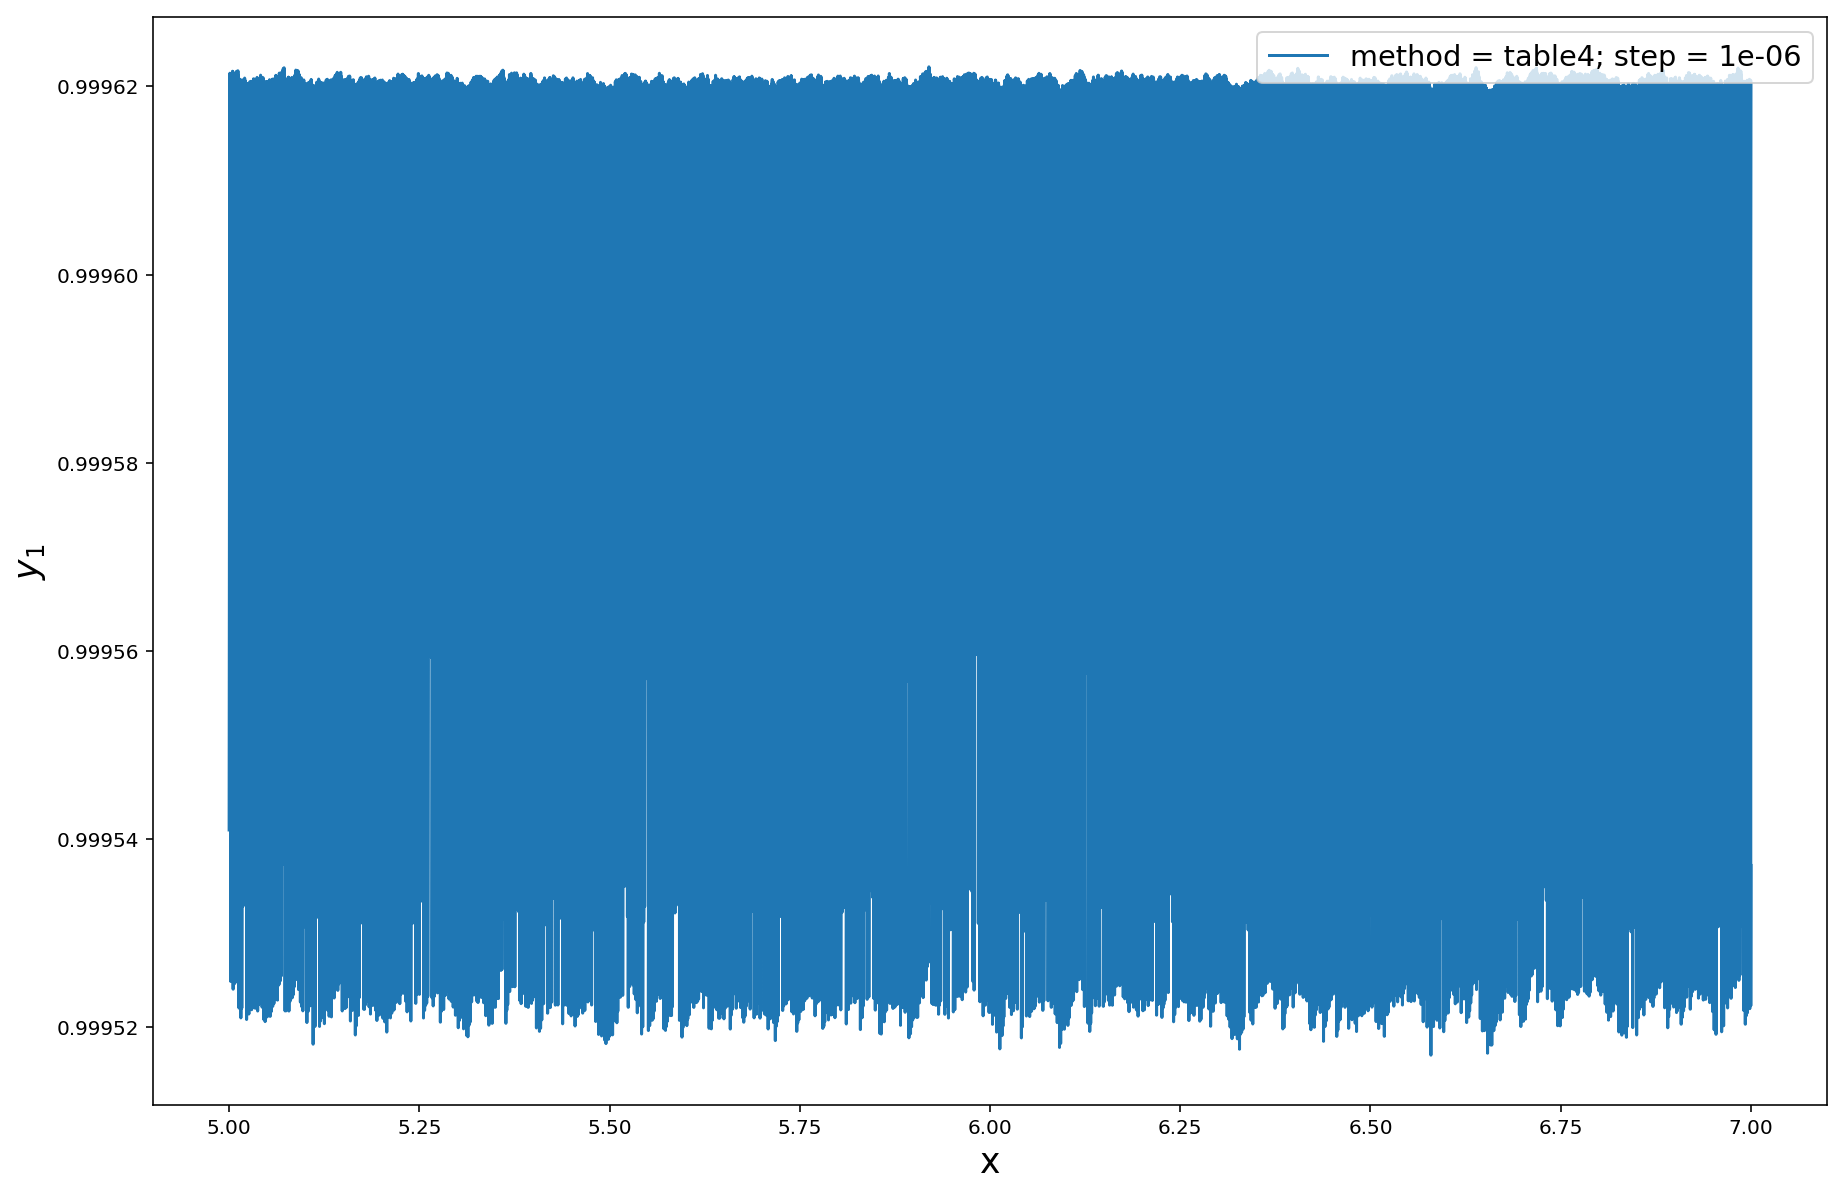

In [97]:
plt.figure(figsize=(15, 10))
plt.plot(x_s_stiff_next, y_s_stiff_next[:, 0], label = 'method = {}; step = {}'.format('table4', 10**(-6)))
#plt.xlim(5, 5.01)
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('$y_1$', fontsize='xx-large')
plt.legend(fontsize='x-large', loc=1);

Увеличим масштаб

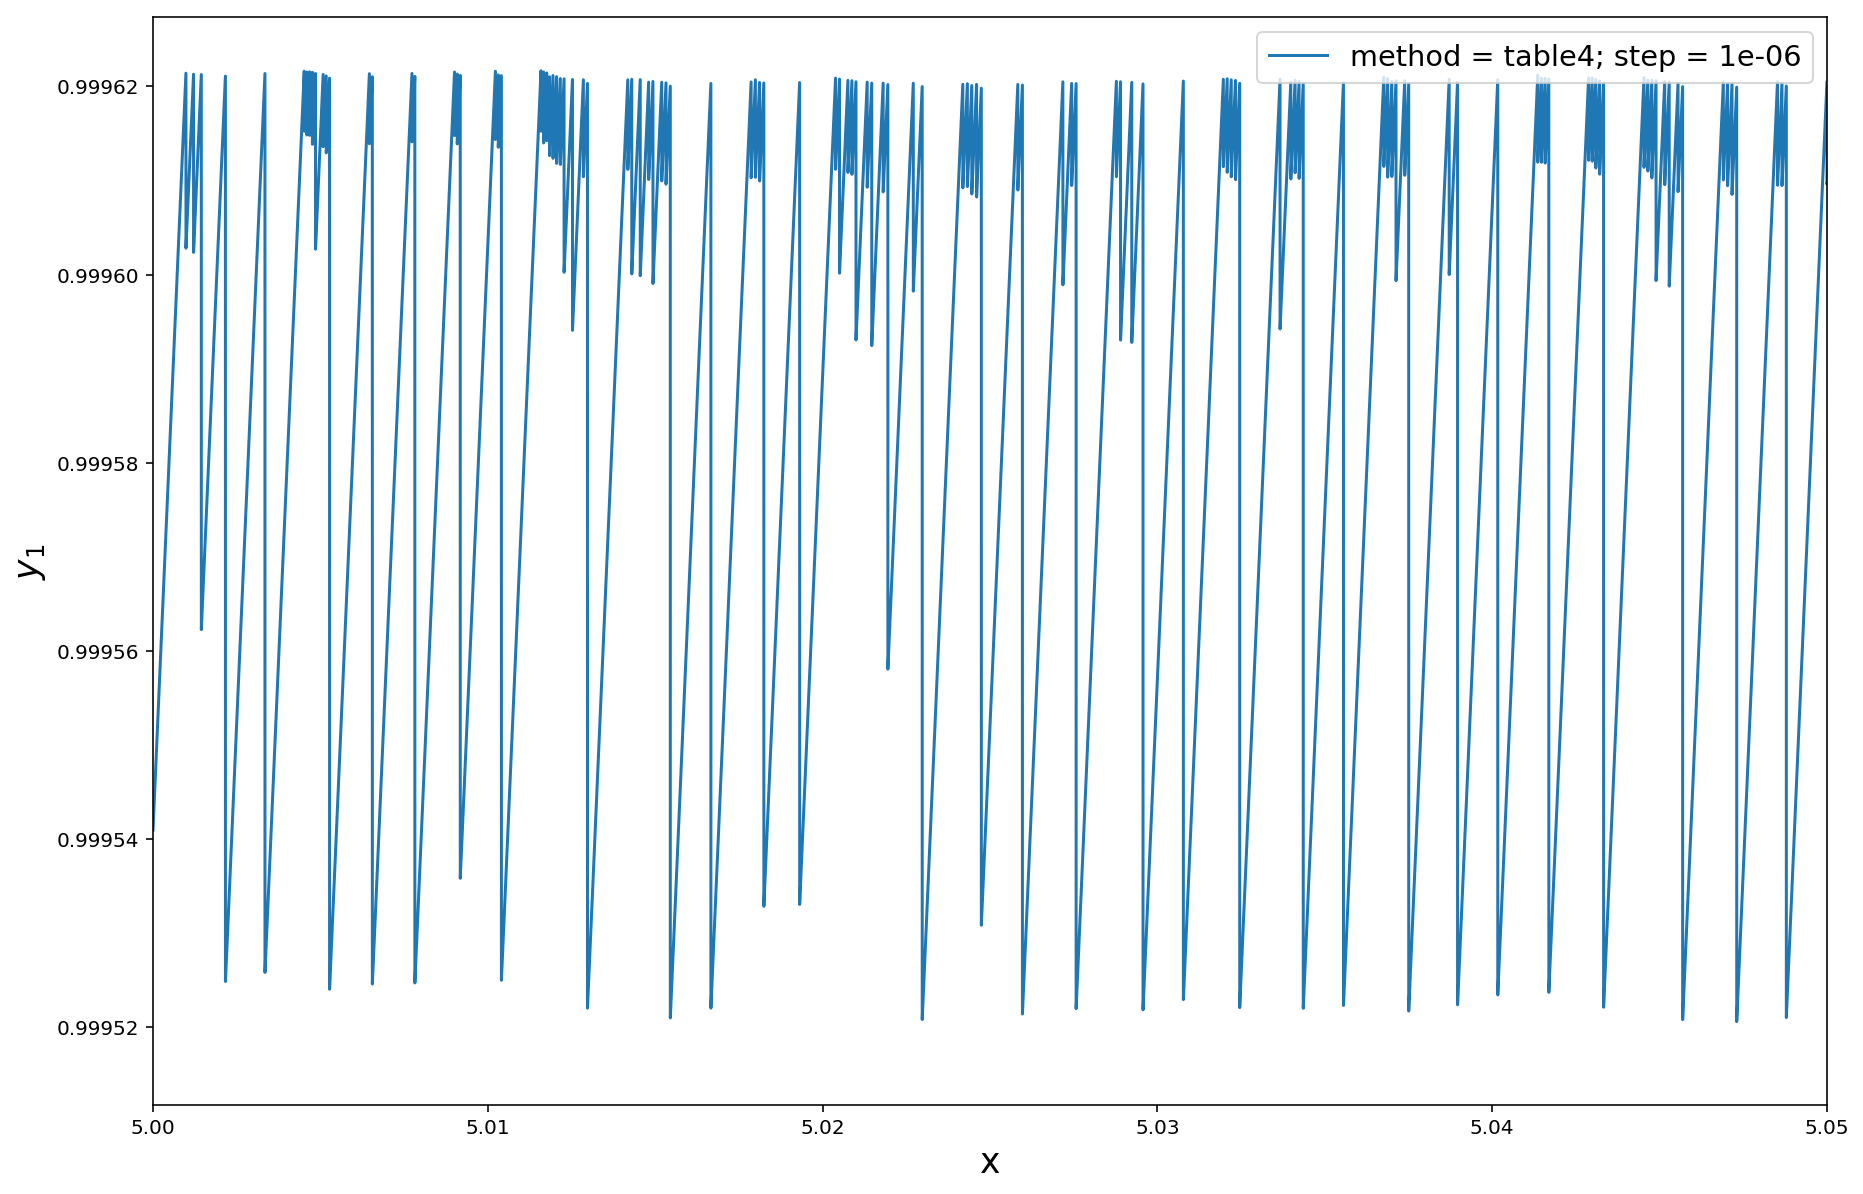

In [98]:
plt.figure(figsize=(15, 10))
plt.plot(x_s_stiff_next, y_s_stiff_next[:, 0], label = 'method = {}; step = {}'.format('table4', 10**(-6)))
plt.xlim(5, 5.05)
plt.xlabel('x', fontsize='xx-large')
plt.ylabel('$y_1$', fontsize='xx-large')
plt.legend(fontsize='x-large', loc=1);

Видны некоторые колебания.

In [63]:
y_s_s, x_s_s = np.vstack((y_s_s, y_s_stiff_next)), np.hstack((x_s_s, x_s_stiff_next))

In [65]:
f = open('special.txt', 'w')
for i in range(len(y_s_s)):
    f.write('{} {} {}\n'.format(x_s_s[i], y_s_s[i, 0], y_s_s[i, 1]))
f.close()